# Snake

In [5]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.random.set_seed(0)

import environments_fully_observable 
import environments_partially_observable
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import os
import random
# import tensorflow as tf
# tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

# GPU configuration
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
TensorFlow version: 2.10.1


## Environment definition

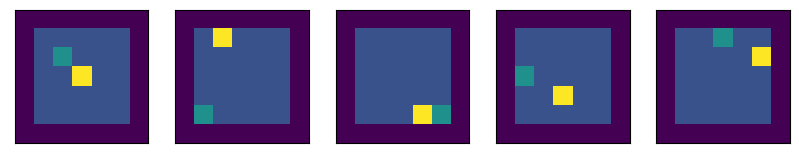

In [6]:
%matplotlib inline
# function to standardize getting an env for the whole notebook
def get_env(n=1000, partially_observable=False):
    # n is the number of boards that you want to simulate parallely
    # size is the size of each board, also considering the borders
    # mask for the partially observable, is the size of the local neighborhood
    size = 7
    if partially_observable:
        e = environments_partially_observable.OriginalSnakeEnvironment(n, size, 3)
    else:
        e = environments_fully_observable.OriginalSnakeEnvironment(n, size)
    # or environments_partially_observable.OriginalSnakeEnvironment(n, size, 2)
    return e
env_ = get_env()
GAMMA = .9
ITERATIONS = 5000

fig,axs=plt.subplots(1,min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")

## DQN Agent

In [7]:
from dqn import DQNAgent

agent = DQNAgent(state_shape=env_.to_state().shape[1:], gamma=GAMMA, n_actions=4, epsilon_start=1., epsilon_end=0.05, epsilon_decay=0.9995, learning_rate=1e-4, target_update_freq=100)

## Training

In [8]:
from training import training

rewards_history_dqn, wall_hits_dqn, fruits_eaten_dqn, loss_history_dqn = training(ITERATIONS, env_, agent, save_weights=True, save_path="weights/", file_name="snake_dqn_weights.h5")

  0%|          | 1/5000 [00:01<2:26:20,  1.76s/it]

Iteration 0: Avg Reward: 0.00, Avg Loss: 0.0428
Fruits eaten: 40, Max fruits eaten: 40
Wall hits: 192


  2%|▏         | 101/5000 [02:23<2:09:00,  1.58s/it]

Iteration 100: Avg Reward: -0.01, Avg Loss: 0.0088
Fruits eaten: 13, Max fruits eaten: 40
Wall hits: 161


  4%|▍         | 201/5000 [05:03<2:08:00,  1.60s/it]

Iteration 200: Avg Reward: -0.01, Avg Loss: 0.0059
Fruits eaten: 20, Max fruits eaten: 40
Wall hits: 184


  6%|▌         | 301/5000 [07:45<2:05:21,  1.60s/it]

Iteration 300: Avg Reward: -0.01, Avg Loss: 0.0059
Fruits eaten: 44, Max fruits eaten: 44
Wall hits: 1


  8%|▊         | 401/5000 [10:27<2:05:54,  1.64s/it]

Iteration 400: Avg Reward: -0.00, Avg Loss: 0.0079
Fruits eaten: 19, Max fruits eaten: 44
Wall hits: 180


 10%|█         | 501/5000 [13:08<2:02:07,  1.63s/it]

Iteration 500: Avg Reward: -0.01, Avg Loss: 0.0066
Fruits eaten: 20, Max fruits eaten: 44
Wall hits: 179


 12%|█▏        | 601/5000 [15:50<2:00:20,  1.64s/it]

Iteration 600: Avg Reward: -0.01, Avg Loss: 0.0077
Fruits eaten: 16, Max fruits eaten: 44
Wall hits: 180


 14%|█▍        | 701/5000 [18:31<1:53:26,  1.58s/it]

Iteration 700: Avg Reward: 0.00, Avg Loss: 0.0104
Fruits eaten: 20, Max fruits eaten: 44
Wall hits: 183


 16%|█▌        | 801/5000 [21:12<1:51:40,  1.60s/it]

Iteration 800: Avg Reward: 0.00, Avg Loss: 0.0100
Fruits eaten: 19, Max fruits eaten: 44
Wall hits: 213


 18%|█▊        | 901/5000 [23:53<1:50:18,  1.61s/it]

Iteration 900: Avg Reward: 0.01, Avg Loss: 0.0101
Fruits eaten: 169, Max fruits eaten: 169
Wall hits: 0


 20%|██        | 1001/5000 [26:35<1:47:58,  1.62s/it]

Iteration 1000: Avg Reward: 0.02, Avg Loss: 0.0116
Fruits eaten: 35, Max fruits eaten: 169
Wall hits: 166


 22%|██▏       | 1101/5000 [29:17<1:47:40,  1.66s/it]

Iteration 1100: Avg Reward: 0.02, Avg Loss: 0.0132
Fruits eaten: 67, Max fruits eaten: 169
Wall hits: 148


 24%|██▍       | 1201/5000 [31:59<1:43:09,  1.63s/it]

Iteration 1200: Avg Reward: 0.03, Avg Loss: 0.0161
Fruits eaten: 37, Max fruits eaten: 169
Wall hits: 189


 26%|██▌       | 1301/5000 [34:39<1:38:23,  1.60s/it]

Iteration 1300: Avg Reward: 0.03, Avg Loss: 0.0180
Fruits eaten: 118, Max fruits eaten: 169
Wall hits: 1


 28%|██▊       | 1401/5000 [37:19<1:34:53,  1.58s/it]

Iteration 1400: Avg Reward: 0.04, Avg Loss: 0.0198
Fruits eaten: 139, Max fruits eaten: 169
Wall hits: 3


 30%|███       | 1501/5000 [40:00<1:32:49,  1.59s/it]

Iteration 1500: Avg Reward: 0.04, Avg Loss: 0.0205
Fruits eaten: 137, Max fruits eaten: 169
Wall hits: 2


 32%|███▏      | 1601/5000 [42:39<1:31:07,  1.61s/it]

Iteration 1600: Avg Reward: 0.05, Avg Loss: 0.0250
Fruits eaten: 303, Max fruits eaten: 303
Wall hits: 7


 34%|███▍      | 1701/5000 [45:19<1:28:47,  1.61s/it]

Iteration 1700: Avg Reward: 0.05, Avg Loss: 0.0280
Fruits eaten: 257, Max fruits eaten: 303
Wall hits: 5


 36%|███▌      | 1801/5000 [47:59<1:24:01,  1.58s/it]

Iteration 1800: Avg Reward: 0.06, Avg Loss: 0.0317
Fruits eaten: 144, Max fruits eaten: 303
Wall hits: 11


 38%|███▊      | 1901/5000 [50:39<1:22:30,  1.60s/it]

Iteration 1900: Avg Reward: 0.06, Avg Loss: 0.0328
Fruits eaten: 59, Max fruits eaten: 303
Wall hits: 84


 40%|████      | 2001/5000 [53:18<1:19:21,  1.59s/it]

Iteration 2000: Avg Reward: 0.07, Avg Loss: 0.0320
Fruits eaten: 316, Max fruits eaten: 316
Wall hits: 0


 42%|████▏     | 2101/5000 [55:59<1:17:33,  1.61s/it]

Iteration 2100: Avg Reward: 0.06, Avg Loss: 0.0300
Fruits eaten: 119, Max fruits eaten: 316
Wall hits: 3


 44%|████▍     | 2201/5000 [58:38<1:14:58,  1.61s/it]

Iteration 2200: Avg Reward: 0.06, Avg Loss: 0.0337
Fruits eaten: 314, Max fruits eaten: 316
Wall hits: 3


 46%|████▌     | 2301/5000 [1:01:19<1:11:55,  1.60s/it]

Iteration 2300: Avg Reward: 0.07, Avg Loss: 0.0355
Fruits eaten: 327, Max fruits eaten: 327
Wall hits: 1


 48%|████▊     | 2401/5000 [1:04:00<1:08:39,  1.59s/it]

Iteration 2400: Avg Reward: 0.06, Avg Loss: 0.0383
Fruits eaten: 297, Max fruits eaten: 327
Wall hits: 1


 50%|█████     | 2501/5000 [1:06:41<1:07:25,  1.62s/it]

Iteration 2500: Avg Reward: 0.07, Avg Loss: 0.0365
Fruits eaten: 95, Max fruits eaten: 327
Wall hits: 86


 52%|█████▏    | 2601/5000 [1:09:21<1:04:22,  1.61s/it]

Iteration 2600: Avg Reward: 0.07, Avg Loss: 0.0392
Fruits eaten: 126, Max fruits eaten: 327
Wall hits: 4


 54%|█████▍    | 2701/5000 [1:12:03<1:01:58,  1.62s/it]

Iteration 2700: Avg Reward: 0.08, Avg Loss: 0.0411
Fruits eaten: 257, Max fruits eaten: 327
Wall hits: 3


 56%|█████▌    | 2801/5000 [1:14:43<59:08,  1.61s/it]  

Iteration 2800: Avg Reward: 0.08, Avg Loss: 0.0394
Fruits eaten: 270, Max fruits eaten: 327
Wall hits: 5


 58%|█████▊    | 2901/5000 [1:17:23<55:27,  1.59s/it]  

Iteration 2900: Avg Reward: 0.09, Avg Loss: 0.0394
Fruits eaten: 297, Max fruits eaten: 327
Wall hits: 3


 60%|██████    | 3001/5000 [1:20:04<53:50,  1.62s/it]

Iteration 3000: Avg Reward: 0.08, Avg Loss: 0.0437
Fruits eaten: 245, Max fruits eaten: 327
Wall hits: 4


 62%|██████▏   | 3101/5000 [1:22:39<51:05,  1.61s/it]

Iteration 3100: Avg Reward: 0.09, Avg Loss: 0.0405
Fruits eaten: 288, Max fruits eaten: 327
Wall hits: 2


 64%|██████▍   | 3201/5000 [1:25:20<48:29,  1.62s/it]

Iteration 3200: Avg Reward: 0.09, Avg Loss: 0.0370
Fruits eaten: 244, Max fruits eaten: 327
Wall hits: 3


 66%|██████▌   | 3301/5000 [1:27:59<44:01,  1.55s/it]

Iteration 3300: Avg Reward: 0.09, Avg Loss: 0.0412
Fruits eaten: 288, Max fruits eaten: 327
Wall hits: 6


 68%|██████▊   | 3401/5000 [1:30:38<44:08,  1.66s/it]

Iteration 3400: Avg Reward: 0.09, Avg Loss: 0.0428
Fruits eaten: 64, Max fruits eaten: 327
Wall hits: 132


 70%|███████   | 3501/5000 [1:33:18<39:52,  1.60s/it]

Iteration 3500: Avg Reward: 0.10, Avg Loss: 0.0462
Fruits eaten: 212, Max fruits eaten: 327
Wall hits: 1


 72%|███████▏  | 3601/5000 [1:35:58<36:29,  1.57s/it]

Iteration 3600: Avg Reward: 0.09, Avg Loss: 0.0449
Fruits eaten: 345, Max fruits eaten: 345
Wall hits: 1


 74%|███████▍  | 3701/5000 [1:38:39<36:23,  1.68s/it]

Iteration 3700: Avg Reward: 0.10, Avg Loss: 0.0400
Fruits eaten: 186, Max fruits eaten: 345
Wall hits: 2


 76%|███████▌  | 3801/5000 [1:41:20<31:59,  1.60s/it]

Iteration 3800: Avg Reward: 0.10, Avg Loss: 0.0367
Fruits eaten: 265, Max fruits eaten: 345
Wall hits: 0


 78%|███████▊  | 3901/5000 [1:44:00<29:45,  1.63s/it]

Iteration 3900: Avg Reward: 0.11, Avg Loss: 0.0343
Fruits eaten: 275, Max fruits eaten: 345
Wall hits: 5


 80%|████████  | 4001/5000 [1:46:41<26:49,  1.61s/it]

Iteration 4000: Avg Reward: 0.10, Avg Loss: 0.0404
Fruits eaten: 310, Max fruits eaten: 345
Wall hits: 2


 82%|████████▏ | 4101/5000 [1:49:21<23:44,  1.58s/it]

Iteration 4100: Avg Reward: 0.10, Avg Loss: 0.0406
Fruits eaten: 135, Max fruits eaten: 345
Wall hits: 2


 84%|████████▍ | 4201/5000 [1:52:01<21:21,  1.60s/it]

Iteration 4200: Avg Reward: 0.10, Avg Loss: 0.0458
Fruits eaten: 284, Max fruits eaten: 345
Wall hits: 2


 86%|████████▌ | 4301/5000 [1:54:42<18:35,  1.60s/it]

Iteration 4300: Avg Reward: 0.10, Avg Loss: 0.0390
Fruits eaten: 293, Max fruits eaten: 345
Wall hits: 1


 88%|████████▊ | 4401/5000 [1:57:22<15:59,  1.60s/it]

Iteration 4400: Avg Reward: 0.11, Avg Loss: 0.0424
Fruits eaten: 251, Max fruits eaten: 345
Wall hits: 4


 90%|█████████ | 4501/5000 [2:00:03<13:51,  1.67s/it]

Iteration 4500: Avg Reward: 0.11, Avg Loss: 0.0385
Fruits eaten: 136, Max fruits eaten: 345
Wall hits: 4


 92%|█████████▏| 4601/5000 [2:02:44<10:45,  1.62s/it]

Iteration 4600: Avg Reward: 0.12, Avg Loss: 0.0377
Fruits eaten: 276, Max fruits eaten: 345
Wall hits: 8


 94%|█████████▍| 4701/5000 [2:05:24<07:51,  1.58s/it]

Iteration 4700: Avg Reward: 0.11, Avg Loss: 0.0421
Fruits eaten: 283, Max fruits eaten: 345
Wall hits: 4


 96%|█████████▌| 4801/5000 [2:08:05<05:18,  1.60s/it]

Iteration 4800: Avg Reward: 0.11, Avg Loss: 0.0436
Fruits eaten: 291, Max fruits eaten: 345
Wall hits: 1


 98%|█████████▊| 4901/5000 [2:10:45<02:40,  1.62s/it]

Iteration 4900: Avg Reward: 0.11, Avg Loss: 0.0448
Fruits eaten: 288, Max fruits eaten: 345
Wall hits: 3


100%|██████████| 5000/5000 [2:13:23<00:00,  1.60s/it]

Model weights saved to weights/snake_dqn_weights.h5
Weights saved to weights/snake_dqn_weights.h5


### Load the weights - DQN Agent

In [9]:
env = get_env()
agent = DQNAgent(state_shape=env.to_state().shape[1:], gamma=GAMMA, n_actions=4, epsilon_start=1., epsilon_end=0.05, epsilon_decay=0.9995, learning_rate=1e-4, target_update_freq=100)

agent.load_weights("weights/snake_dqn_weights.h5")
agent.epsilon = agent.epsilon_end

rewards_history_loaded = []
wall_hits_loaded = []
fruits_eaten_loaded = []

for iteration in trange(ITERATIONS):
    state = tf.constant(env.to_state())
    actions = agent.select_action(state)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_loaded.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_loaded.append(fruits_eaten_count)
    rewards_history_loaded.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

print(f"Avg Reward: {np.mean(rewards_history_loaded):.2f}")
print(f"Avg Wall Hits: {np.mean(wall_hits_loaded):.2f}")
print(f"Avg Fruits Eaten: {np.mean(fruits_eaten_loaded):.2f}")

Model weights loaded from weights/snake_dqn_weights.h5


100%|██████████| 5000/5000 [02:28<00:00, 33.74it/s]

Avg Reward: 0.12
Avg Wall Hits: 9.29
Avg Fruits Eaten: 262.22


### Load the weights - Testing on Partially Observable Environment

In [10]:
env = get_env(partially_observable=True)
agent = DQNAgent(state_shape=env.to_state().shape[1:], gamma=GAMMA, n_actions=4, epsilon_start=1., epsilon_end=0.05, epsilon_decay=0.9995, learning_rate=1e-4, target_update_freq=100)

agent.load_weights("weights/snake_dqn_weights.h5")
agent.epsilon = agent.epsilon_end

rewards_history_loaded_po = []
wall_hits_loaded_po = []
fruits_eaten_loaded_po = []

for iteration in trange(ITERATIONS):
    state = tf.constant(env.to_state())
    actions = agent.select_action(state)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_loaded_po.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_loaded_po.append(fruits_eaten_count)
    rewards_history_loaded_po.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

print(f"Avg Reward: {np.mean(rewards_history_loaded_po):.2f}")
print(f"Avg Wall Hits: {np.mean(wall_hits_loaded_po):.2f}")
print(f"Avg Fruits Eaten: {np.mean(fruits_eaten_loaded_po):.2f}")

Model weights loaded from weights/snake_dqn_weights.h5


100%|██████████| 5000/5000 [01:38<00:00, 51.00it/s]

Avg Reward: -0.09
Avg Wall Hits: 931.03
Avg Fruits Eaten: 2.86


Here we train the model on the partially observable environment

In [11]:
env = get_env(partially_observable=True)
agent = DQNAgent(state_shape=env.to_state().shape[1:], gamma=GAMMA, n_actions=4, epsilon_start=1., epsilon_end=0.05, epsilon_decay=0.9995, learning_rate=1e-4, target_update_freq=100)

rewards_history_dqn_po, wall_hits_dqn_po, fruits_eaten_dqn_po, loss_history_dqn_po = training(ITERATIONS, env, agent, save_weights=True, save_path="weights/", file_name="snake_dqn_weights_po.h5")

  0%|          | 1/5000 [00:01<2:18:02,  1.66s/it]

Iteration 0: Avg Reward: -0.00, Avg Loss: 0.0275
Fruits eaten: 39, Max fruits eaten: 39
Wall hits: 208


  2%|▏         | 101/5000 [02:37<2:05:46,  1.54s/it]

Iteration 100: Avg Reward: -0.01, Avg Loss: 0.0082
Fruits eaten: 14, Max fruits eaten: 39
Wall hits: 195


  4%|▍         | 201/5000 [05:14<2:08:03,  1.60s/it]

Iteration 200: Avg Reward: -0.01, Avg Loss: 0.0051
Fruits eaten: 16, Max fruits eaten: 39
Wall hits: 156


  6%|▌         | 301/5000 [07:53<2:06:09,  1.61s/it]

Iteration 300: Avg Reward: -0.00, Avg Loss: 0.0074
Fruits eaten: 224, Max fruits eaten: 224
Wall hits: 1


  8%|▊         | 401/5000 [10:34<2:01:10,  1.58s/it]

Iteration 400: Avg Reward: -0.01, Avg Loss: 0.0116
Fruits eaten: 34, Max fruits eaten: 224
Wall hits: 145


 10%|█         | 501/5000 [13:14<1:58:44,  1.58s/it]

Iteration 500: Avg Reward: 0.00, Avg Loss: 0.0174
Fruits eaten: 77, Max fruits eaten: 224
Wall hits: 105


 12%|█▏        | 601/5000 [15:54<1:57:56,  1.61s/it]

Iteration 600: Avg Reward: 0.01, Avg Loss: 0.0222
Fruits eaten: 54, Max fruits eaten: 224
Wall hits: 95


 14%|█▍        | 701/5000 [18:34<1:55:16,  1.61s/it]

Iteration 700: Avg Reward: 0.01, Avg Loss: 0.0240
Fruits eaten: 21, Max fruits eaten: 224
Wall hits: 223


 16%|█▌        | 801/5000 [21:11<1:50:08,  1.57s/it]

Iteration 800: Avg Reward: 0.02, Avg Loss: 0.0243
Fruits eaten: 142, Max fruits eaten: 224
Wall hits: 0


 18%|█▊        | 901/5000 [23:48<1:49:18,  1.60s/it]

Iteration 900: Avg Reward: 0.02, Avg Loss: 0.0282
Fruits eaten: 38, Max fruits eaten: 224
Wall hits: 147


 20%|██        | 1001/5000 [26:29<1:47:40,  1.62s/it]

Iteration 1000: Avg Reward: 0.03, Avg Loss: 0.0261
Fruits eaten: 145, Max fruits eaten: 224
Wall hits: 0


 22%|██▏       | 1101/5000 [29:08<1:44:03,  1.60s/it]

Iteration 1100: Avg Reward: 0.02, Avg Loss: 0.0312
Fruits eaten: 65, Max fruits eaten: 224
Wall hits: 110


 24%|██▍       | 1201/5000 [31:48<1:38:47,  1.56s/it]

Iteration 1200: Avg Reward: 0.03, Avg Loss: 0.0288
Fruits eaten: 129, Max fruits eaten: 224
Wall hits: 0


 26%|██▌       | 1301/5000 [34:29<1:41:03,  1.64s/it]

Iteration 1300: Avg Reward: 0.03, Avg Loss: 0.0339
Fruits eaten: 71, Max fruits eaten: 224
Wall hits: 146


 28%|██▊       | 1401/5000 [37:10<1:35:58,  1.60s/it]

Iteration 1400: Avg Reward: 0.04, Avg Loss: 0.0375
Fruits eaten: 292, Max fruits eaten: 292
Wall hits: 1


 30%|███       | 1501/5000 [39:51<1:37:19,  1.67s/it]

Iteration 1500: Avg Reward: 0.05, Avg Loss: 0.0385
Fruits eaten: 74, Max fruits eaten: 292
Wall hits: 110


 32%|███▏      | 1601/5000 [42:31<1:31:32,  1.62s/it]

Iteration 1600: Avg Reward: 0.03, Avg Loss: 0.0407
Fruits eaten: 273, Max fruits eaten: 292
Wall hits: 0


 34%|███▍      | 1701/5000 [45:12<1:28:23,  1.61s/it]

Iteration 1700: Avg Reward: 0.05, Avg Loss: 0.0444
Fruits eaten: 300, Max fruits eaten: 300
Wall hits: 1


 36%|███▌      | 1801/5000 [47:53<1:25:24,  1.60s/it]

Iteration 1800: Avg Reward: 0.05, Avg Loss: 0.0416
Fruits eaten: 268, Max fruits eaten: 300
Wall hits: 1


 38%|███▊      | 1901/5000 [50:32<1:23:10,  1.61s/it]

Iteration 1900: Avg Reward: 0.05, Avg Loss: 0.0424
Fruits eaten: 257, Max fruits eaten: 300
Wall hits: 1


 40%|████      | 2001/5000 [53:13<1:20:17,  1.61s/it]

Iteration 2000: Avg Reward: 0.07, Avg Loss: 0.0360
Fruits eaten: 291, Max fruits eaten: 300
Wall hits: 1


 42%|████▏     | 2101/5000 [55:54<1:18:32,  1.63s/it]

Iteration 2100: Avg Reward: 0.06, Avg Loss: 0.0393
Fruits eaten: 30, Max fruits eaten: 300
Wall hits: 145


 44%|████▍     | 2201/5000 [58:34<1:15:18,  1.61s/it]

Iteration 2200: Avg Reward: 0.06, Avg Loss: 0.0387
Fruits eaten: 64, Max fruits eaten: 300
Wall hits: 144


 46%|████▌     | 2301/5000 [1:01:15<1:12:31,  1.61s/it]

Iteration 2300: Avg Reward: 0.05, Avg Loss: 0.0424
Fruits eaten: 85, Max fruits eaten: 300
Wall hits: 0


 48%|████▊     | 2401/5000 [1:03:56<1:09:57,  1.61s/it]

Iteration 2400: Avg Reward: 0.07, Avg Loss: 0.0401
Fruits eaten: 74, Max fruits eaten: 300
Wall hits: 126


 50%|█████     | 2501/5000 [1:06:37<1:07:08,  1.61s/it]

Iteration 2500: Avg Reward: 0.09, Avg Loss: 0.0360
Fruits eaten: 75, Max fruits eaten: 300
Wall hits: 159


 52%|█████▏    | 2601/5000 [1:09:18<1:04:57,  1.62s/it]

Iteration 2600: Avg Reward: 0.07, Avg Loss: 0.0484
Fruits eaten: 223, Max fruits eaten: 300
Wall hits: 1


 54%|█████▍    | 2701/5000 [1:11:59<1:01:56,  1.62s/it]

Iteration 2700: Avg Reward: 0.09, Avg Loss: 0.0395
Fruits eaten: 286, Max fruits eaten: 300
Wall hits: 6


 56%|█████▌    | 2801/5000 [1:14:39<59:22,  1.62s/it]  

Iteration 2800: Avg Reward: 0.09, Avg Loss: 0.0371
Fruits eaten: 283, Max fruits eaten: 300
Wall hits: 4


 58%|█████▊    | 2901/5000 [1:17:19<56:07,  1.60s/it]

Iteration 2900: Avg Reward: 0.08, Avg Loss: 0.0331
Fruits eaten: 266, Max fruits eaten: 300
Wall hits: 5


 60%|██████    | 3001/5000 [1:19:59<52:07,  1.56s/it]

Iteration 3000: Avg Reward: 0.08, Avg Loss: 0.0342
Fruits eaten: 286, Max fruits eaten: 300
Wall hits: 1


 62%|██████▏   | 3101/5000 [1:22:40<51:18,  1.62s/it]

Iteration 3100: Avg Reward: 0.07, Avg Loss: 0.0354
Fruits eaten: 164, Max fruits eaten: 300
Wall hits: 0


 64%|██████▍   | 3201/5000 [1:25:20<48:54,  1.63s/it]

Iteration 3200: Avg Reward: 0.08, Avg Loss: 0.0291
Fruits eaten: 265, Max fruits eaten: 300
Wall hits: 2


 66%|██████▌   | 3301/5000 [1:28:01<46:19,  1.64s/it]

Iteration 3300: Avg Reward: 0.10, Avg Loss: 0.0277
Fruits eaten: 228, Max fruits eaten: 300
Wall hits: 6


 68%|██████▊   | 3401/5000 [1:30:42<42:33,  1.60s/it]

Iteration 3400: Avg Reward: 0.08, Avg Loss: 0.0384
Fruits eaten: 270, Max fruits eaten: 300
Wall hits: 2


 70%|███████   | 3501/5000 [1:33:23<40:23,  1.62s/it]

Iteration 3500: Avg Reward: 0.10, Avg Loss: 0.0326
Fruits eaten: 254, Max fruits eaten: 300
Wall hits: 0


 72%|███████▏  | 3601/5000 [1:36:03<37:28,  1.61s/it]

Iteration 3600: Avg Reward: 0.10, Avg Loss: 0.0364
Fruits eaten: 271, Max fruits eaten: 300
Wall hits: 2


 74%|███████▍  | 3701/5000 [1:38:43<35:19,  1.63s/it]

Iteration 3700: Avg Reward: 0.09, Avg Loss: 0.0332
Fruits eaten: 254, Max fruits eaten: 300
Wall hits: 1


 76%|███████▌  | 3801/5000 [1:41:23<32:18,  1.62s/it]

Iteration 3800: Avg Reward: 0.11, Avg Loss: 0.0369
Fruits eaten: 289, Max fruits eaten: 300
Wall hits: 1


 78%|███████▊  | 3901/5000 [1:44:03<28:49,  1.57s/it]

Iteration 3900: Avg Reward: 0.10, Avg Loss: 0.0388
Fruits eaten: 268, Max fruits eaten: 300
Wall hits: 3


 80%|████████  | 4001/5000 [1:46:43<26:28,  1.59s/it]

Iteration 4000: Avg Reward: 0.10, Avg Loss: 0.0452
Fruits eaten: 273, Max fruits eaten: 300
Wall hits: 1


 82%|████████▏ | 4101/5000 [1:49:23<24:15,  1.62s/it]

Iteration 4100: Avg Reward: 0.10, Avg Loss: 0.0438
Fruits eaten: 247, Max fruits eaten: 300
Wall hits: 4


 84%|████████▍ | 4201/5000 [1:52:04<21:32,  1.62s/it]

Iteration 4200: Avg Reward: 0.10, Avg Loss: 0.0347
Fruits eaten: 156, Max fruits eaten: 300
Wall hits: 1


 86%|████████▌ | 4301/5000 [1:54:44<18:38,  1.60s/it]

Iteration 4300: Avg Reward: 0.10, Avg Loss: 0.0323
Fruits eaten: 266, Max fruits eaten: 300
Wall hits: 0


 88%|████████▊ | 4401/5000 [1:57:25<15:48,  1.58s/it]

Iteration 4400: Avg Reward: 0.11, Avg Loss: 0.0351
Fruits eaten: 258, Max fruits eaten: 300
Wall hits: 5


 90%|█████████ | 4501/5000 [2:00:05<13:25,  1.61s/it]

Iteration 4500: Avg Reward: 0.11, Avg Loss: 0.0330
Fruits eaten: 269, Max fruits eaten: 300
Wall hits: 1


 92%|█████████▏| 4601/5000 [2:02:45<10:54,  1.64s/it]

Iteration 4600: Avg Reward: 0.10, Avg Loss: 0.0427
Fruits eaten: 248, Max fruits eaten: 300
Wall hits: 0


 94%|█████████▍| 4701/5000 [2:05:25<07:58,  1.60s/it]

Iteration 4700: Avg Reward: 0.11, Avg Loss: 0.0454
Fruits eaten: 303, Max fruits eaten: 303
Wall hits: 1


 96%|█████████▌| 4801/5000 [2:08:06<05:13,  1.58s/it]

Iteration 4800: Avg Reward: 0.11, Avg Loss: 0.0425
Fruits eaten: 267, Max fruits eaten: 303
Wall hits: 0


 98%|█████████▊| 4901/5000 [2:10:47<02:38,  1.60s/it]

Iteration 4900: Avg Reward: 0.11, Avg Loss: 0.0466
Fruits eaten: 28, Max fruits eaten: 303
Wall hits: 163


100%|██████████| 5000/5000 [2:13:25<00:00,  1.60s/it]

Model weights saved to weights/snake_dqn_weights_po.h5
Weights saved to weights/snake_dqn_weights_po.h5


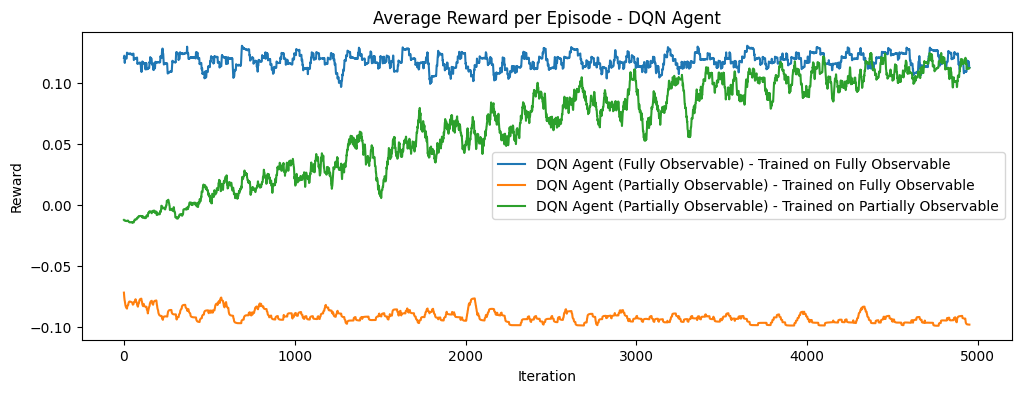

In [12]:
window = 50

def moving_average(data, window):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 4))

plt.plot(moving_average(rewards_history_loaded, window), label='DQN Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(rewards_history_loaded_po, window), label='DQN Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(rewards_history_dqn_po, window), label='DQN Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Reward per Episode - DQN Agent')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend()
plt.savefig("plots/rewards_dqn.png", bbox_inches='tight')
plt.show()
plt.close()

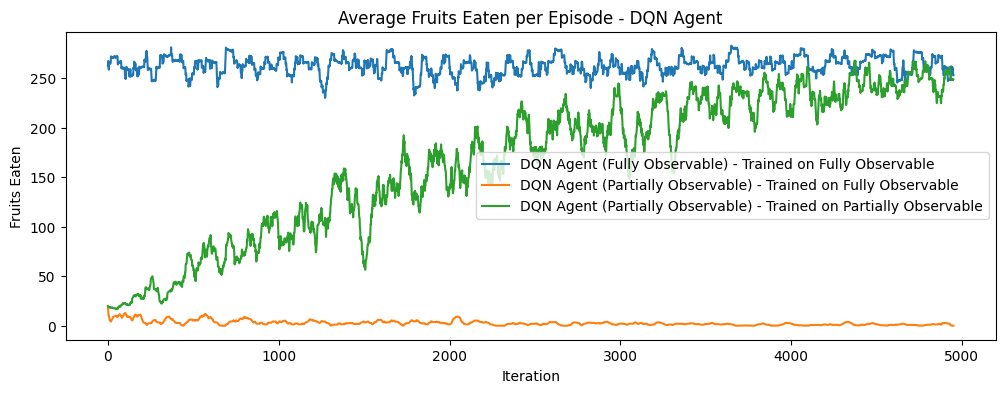

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(fruits_eaten_loaded, window), label='DQN Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(fruits_eaten_loaded_po, window), label='DQN Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(fruits_eaten_dqn_po, window), label='DQN Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Fruits Eaten per Episode - DQN Agent')
plt.xlabel('Iteration')
plt.ylabel('Fruits Eaten')
plt.legend()
plt.savefig("plots/fruits_eaten_dqn.png", bbox_inches='tight')
plt.show()
plt.close()

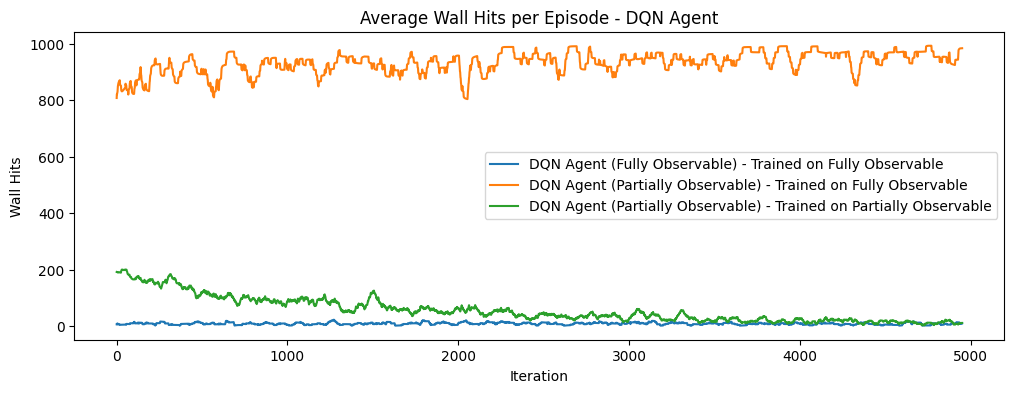

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(wall_hits_loaded, window), label='DQN Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(wall_hits_loaded_po, window), label='DQN Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(wall_hits_dqn_po, window), label='DQN Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Wall Hits per Episode - DQN Agent')
plt.xlabel('Iteration')
plt.ylabel('Wall Hits')
plt.legend()
plt.savefig("plots/wall_hits_dqn.png", bbox_inches='tight')
plt.show()
plt.close()

## A2C Agent

### Training

In [15]:
from a2c import A2CAgent

env_ = get_env()
agent = A2CAgent(state_shape=env_.to_state().shape[1:], n_actions=4, gamma=GAMMA, learning_rate=5e-5, entropy_beta=0.0001)

rewards_history_ac, wall_hits_ac, fruits_eaten_ac, loss_history_ac = training(ITERATIONS, env_, agent, save_weights=True, save_path="weights/", file_name="snake_a2c_weights.h5")

  0%|          | 4/5000 [00:00<08:33,  9.74it/s]

Iteration 0: Avg Reward: -0.00, Avg Loss: 0.0082
Fruits eaten: 30, Max fruits eaten: 30
Wall hits: 194


  2%|▏         | 105/5000 [00:03<02:54, 28.03it/s]

Iteration 100: Avg Reward: -0.01, Avg Loss: 0.0063
Fruits eaten: 20, Max fruits eaten: 30
Wall hits: 204


  4%|▍         | 206/5000 [00:07<02:47, 28.57it/s]

Iteration 200: Avg Reward: -0.01, Avg Loss: 0.0030
Fruits eaten: 11, Max fruits eaten: 30
Wall hits: 183


  6%|▌         | 304/5000 [00:11<03:00, 26.00it/s]

Iteration 300: Avg Reward: -0.01, Avg Loss: -0.0014
Fruits eaten: 28, Max fruits eaten: 30
Wall hits: 168


  8%|▊         | 405/5000 [00:14<02:37, 29.16it/s]

Iteration 400: Avg Reward: -0.01, Avg Loss: -0.0091
Fruits eaten: 17, Max fruits eaten: 30
Wall hits: 166


 10%|█         | 505/5000 [00:17<02:36, 28.74it/s]

Iteration 500: Avg Reward: -0.01, Avg Loss: -0.0172
Fruits eaten: 17, Max fruits eaten: 30
Wall hits: 128


 12%|█▏        | 604/5000 [00:21<02:30, 29.20it/s]

Iteration 600: Avg Reward: -0.01, Avg Loss: -0.0265
Fruits eaten: 23, Max fruits eaten: 30
Wall hits: 89


 14%|█▍        | 703/5000 [00:24<02:26, 29.32it/s]

Iteration 700: Avg Reward: -0.01, Avg Loss: -0.0291
Fruits eaten: 20, Max fruits eaten: 30
Wall hits: 75


 16%|█▌        | 804/5000 [00:28<02:50, 24.57it/s]

Iteration 800: Avg Reward: -0.00, Avg Loss: -0.0347
Fruits eaten: 24, Max fruits eaten: 30
Wall hits: 52


 18%|█▊        | 903/5000 [00:32<02:41, 25.38it/s]

Iteration 900: Avg Reward: 0.00, Avg Loss: -0.0364
Fruits eaten: 18, Max fruits eaten: 30
Wall hits: 26


 20%|██        | 1004/5000 [00:35<02:34, 25.79it/s]

Iteration 1000: Avg Reward: 0.00, Avg Loss: -0.0412
Fruits eaten: 25, Max fruits eaten: 30
Wall hits: 41


 22%|██▏       | 1105/5000 [00:39<02:25, 26.77it/s]

Iteration 1100: Avg Reward: 0.01, Avg Loss: -0.0395
Fruits eaten: 37, Max fruits eaten: 37
Wall hits: 16


 24%|██▍       | 1206/5000 [00:42<02:15, 28.10it/s]

Iteration 1200: Avg Reward: 0.01, Avg Loss: -0.0361
Fruits eaten: 50, Max fruits eaten: 50
Wall hits: 21


 26%|██▌       | 1306/5000 [00:46<02:11, 27.99it/s]

Iteration 1300: Avg Reward: 0.01, Avg Loss: -0.0414
Fruits eaten: 48, Max fruits eaten: 50
Wall hits: 6


 28%|██▊       | 1405/5000 [00:50<02:11, 27.27it/s]

Iteration 1400: Avg Reward: 0.02, Avg Loss: -0.0452
Fruits eaten: 51, Max fruits eaten: 51
Wall hits: 14


 30%|███       | 1505/5000 [00:54<02:10, 26.71it/s]

Iteration 1500: Avg Reward: 0.02, Avg Loss: -0.0474
Fruits eaten: 58, Max fruits eaten: 58
Wall hits: 7


 32%|███▏      | 1604/5000 [00:58<02:17, 24.69it/s]

Iteration 1600: Avg Reward: 0.03, Avg Loss: -0.0450
Fruits eaten: 69, Max fruits eaten: 69
Wall hits: 4


 34%|███▍      | 1706/5000 [01:02<02:07, 25.77it/s]

Iteration 1700: Avg Reward: 0.03, Avg Loss: -0.0356
Fruits eaten: 82, Max fruits eaten: 82
Wall hits: 29


 36%|███▌      | 1805/5000 [01:06<02:02, 25.99it/s]

Iteration 1800: Avg Reward: 0.03, Avg Loss: -0.0409
Fruits eaten: 75, Max fruits eaten: 82
Wall hits: 27


 38%|███▊      | 1904/5000 [01:10<02:13, 23.20it/s]

Iteration 1900: Avg Reward: 0.02, Avg Loss: -0.0424
Fruits eaten: 58, Max fruits eaten: 82
Wall hits: 31


 40%|████      | 2006/5000 [01:14<01:55, 25.89it/s]

Iteration 2000: Avg Reward: 0.02, Avg Loss: -0.0435
Fruits eaten: 47, Max fruits eaten: 82
Wall hits: 43


 42%|████▏     | 2105/5000 [01:18<01:52, 25.73it/s]

Iteration 2100: Avg Reward: 0.02, Avg Loss: -0.0431
Fruits eaten: 58, Max fruits eaten: 82
Wall hits: 37


 44%|████▍     | 2204/5000 [01:22<01:53, 24.55it/s]

Iteration 2200: Avg Reward: 0.02, Avg Loss: -0.0451
Fruits eaten: 54, Max fruits eaten: 82
Wall hits: 21


 46%|████▌     | 2306/5000 [01:26<01:50, 24.49it/s]

Iteration 2300: Avg Reward: 0.03, Avg Loss: -0.0465
Fruits eaten: 69, Max fruits eaten: 82
Wall hits: 14


 48%|████▊     | 2405/5000 [01:30<01:43, 25.01it/s]

Iteration 2400: Avg Reward: 0.03, Avg Loss: -0.0383
Fruits eaten: 86, Max fruits eaten: 86
Wall hits: 7


 50%|█████     | 2504/5000 [01:34<01:37, 25.61it/s]

Iteration 2500: Avg Reward: 0.04, Avg Loss: -0.0331
Fruits eaten: 117, Max fruits eaten: 117
Wall hits: 6


 52%|█████▏    | 2606/5000 [01:38<01:36, 24.83it/s]

Iteration 2600: Avg Reward: 0.04, Avg Loss: -0.0293
Fruits eaten: 112, Max fruits eaten: 117
Wall hits: 7


 54%|█████▍    | 2705/5000 [01:42<01:33, 24.47it/s]

Iteration 2700: Avg Reward: 0.04, Avg Loss: -0.0261
Fruits eaten: 96, Max fruits eaten: 117
Wall hits: 1


 56%|█████▌    | 2804/5000 [01:47<01:39, 22.06it/s]

Iteration 2800: Avg Reward: 0.04, Avg Loss: -0.0259
Fruits eaten: 100, Max fruits eaten: 117
Wall hits: 4


 58%|█████▊    | 2903/5000 [01:51<01:24, 24.88it/s]

Iteration 2900: Avg Reward: 0.04, Avg Loss: -0.0203
Fruits eaten: 86, Max fruits eaten: 117
Wall hits: 1


 60%|██████    | 3005/5000 [01:55<01:24, 23.53it/s]

Iteration 3000: Avg Reward: 0.04, Avg Loss: -0.0214
Fruits eaten: 90, Max fruits eaten: 117
Wall hits: 5


 62%|██████▏   | 3104/5000 [01:59<01:17, 24.38it/s]

Iteration 3100: Avg Reward: 0.05, Avg Loss: -0.0213
Fruits eaten: 110, Max fruits eaten: 117
Wall hits: 1


 64%|██████▍   | 3206/5000 [02:03<01:12, 24.84it/s]

Iteration 3200: Avg Reward: 0.05, Avg Loss: -0.0153
Fruits eaten: 133, Max fruits eaten: 133
Wall hits: 3


 66%|██████▌   | 3305/5000 [02:08<01:11, 23.71it/s]

Iteration 3300: Avg Reward: 0.05, Avg Loss: -0.0123
Fruits eaten: 97, Max fruits eaten: 133
Wall hits: 2


 68%|██████▊   | 3404/5000 [02:12<01:17, 20.50it/s]

Iteration 3400: Avg Reward: 0.05, Avg Loss: -0.0082
Fruits eaten: 113, Max fruits eaten: 133
Wall hits: 1


 70%|███████   | 3506/5000 [02:16<01:00, 24.90it/s]

Iteration 3500: Avg Reward: 0.05, Avg Loss: -0.0183
Fruits eaten: 116, Max fruits eaten: 133
Wall hits: 1


 72%|███████▏  | 3605/5000 [02:20<00:56, 24.71it/s]

Iteration 3600: Avg Reward: 0.05, Avg Loss: -0.0078
Fruits eaten: 120, Max fruits eaten: 133
Wall hits: 1


 74%|███████▍  | 3704/5000 [02:25<00:53, 24.09it/s]

Iteration 3700: Avg Reward: 0.05, Avg Loss: -0.0052
Fruits eaten: 127, Max fruits eaten: 133
Wall hits: 0


 76%|███████▌  | 3806/5000 [02:29<00:49, 24.24it/s]

Iteration 3800: Avg Reward: 0.05, Avg Loss: -0.0027
Fruits eaten: 121, Max fruits eaten: 133
Wall hits: 3


 78%|███████▊  | 3905/5000 [02:33<00:44, 24.36it/s]

Iteration 3900: Avg Reward: 0.05, Avg Loss: 0.0028
Fruits eaten: 123, Max fruits eaten: 133
Wall hits: 1


 80%|████████  | 4004/5000 [02:37<00:41, 24.18it/s]

Iteration 4000: Avg Reward: 0.05, Avg Loss: 0.0032
Fruits eaten: 121, Max fruits eaten: 133
Wall hits: 0


 82%|████████▏ | 4106/5000 [02:42<00:38, 23.22it/s]

Iteration 4100: Avg Reward: 0.06, Avg Loss: 0.0048
Fruits eaten: 146, Max fruits eaten: 146
Wall hits: 3


 84%|████████▍ | 4205/5000 [02:46<00:34, 23.36it/s]

Iteration 4200: Avg Reward: 0.06, Avg Loss: 0.0095
Fruits eaten: 127, Max fruits eaten: 146
Wall hits: 0


 86%|████████▌ | 4304/5000 [02:50<00:28, 24.09it/s]

Iteration 4300: Avg Reward: 0.06, Avg Loss: 0.0121
Fruits eaten: 144, Max fruits eaten: 146
Wall hits: 0


 88%|████████▊ | 4403/5000 [02:55<00:25, 23.30it/s]

Iteration 4400: Avg Reward: 0.06, Avg Loss: 0.0163
Fruits eaten: 106, Max fruits eaten: 146
Wall hits: 2


 90%|█████████ | 4505/5000 [02:59<00:20, 24.15it/s]

Iteration 4500: Avg Reward: 0.06, Avg Loss: 0.0141
Fruits eaten: 128, Max fruits eaten: 146
Wall hits: 1


 92%|█████████▏| 4604/5000 [03:04<00:16, 24.20it/s]

Iteration 4600: Avg Reward: 0.06, Avg Loss: 0.0173
Fruits eaten: 144, Max fruits eaten: 146
Wall hits: 1


 94%|█████████▍| 4703/5000 [03:08<00:12, 23.86it/s]

Iteration 4700: Avg Reward: 0.06, Avg Loss: 0.0195
Fruits eaten: 153, Max fruits eaten: 153
Wall hits: 1


 96%|█████████▌| 4805/5000 [03:12<00:08, 23.92it/s]

Iteration 4800: Avg Reward: 0.06, Avg Loss: 0.0164
Fruits eaten: 139, Max fruits eaten: 153
Wall hits: 0


 98%|█████████▊| 4904/5000 [03:17<00:04, 23.44it/s]

Iteration 4900: Avg Reward: 0.06, Avg Loss: 0.0180
Fruits eaten: 133, Max fruits eaten: 153
Wall hits: 0


100%|██████████| 5000/5000 [03:21<00:00, 24.82it/s]

Model weights saved to weights/snake_a2c_weights.h5
Weights saved to weights/snake_a2c_weights.h5


### Load the weights - A2C Agent

In [16]:
env = get_env()
agent = A2CAgent(state_shape=env.to_state().shape[1:], n_actions=4, gamma=GAMMA, learning_rate=5e-5, entropy_beta=0.0001)
agent.load_weights("weights/snake_a2c_weights.h5")

rewards_history_loaded_ac = []
wall_hits_loaded_ac = []
fruits_eaten_loaded_ac = []

for iteration in trange(ITERATIONS):
    state = tf.constant(env.to_state())
    actions = agent.select_action(state)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_loaded_ac.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_loaded_ac.append(fruits_eaten_count)
    rewards_history_loaded_ac.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

print(f"Avg Reward: {np.mean(rewards_history_loaded_ac):.2f}")
print(f"Avg Wall Hits: {np.mean(wall_hits_loaded_ac):.2f}")
print(f"Avg Fruits Eaten: {np.mean(fruits_eaten_loaded_ac):.2f}")

Model weights loaded from weights/snake_a2c_weights.h5


100%|██████████| 5000/5000 [02:05<00:00, 39.83it/s]

Avg Reward: 0.06
Avg Wall Hits: 0.75
Avg Fruits Eaten: 125.33


### Load the weights - Testing on Partially Observable Environment

In [17]:
env = get_env(partially_observable=True)
agent = A2CAgent(state_shape=env.to_state().shape[1:], n_actions=4, gamma=GAMMA, learning_rate=5e-5, entropy_beta=0.0001)
agent.load_weights("weights/snake_a2c_weights.h5")

rewards_history_loaded_ac_po = []
wall_hits_loaded_ac_po = []
fruits_eaten_loaded_ac_po = []
loss_history_loaded_ac_po = []

for iteration in trange(ITERATIONS):
    state = tf.constant(env.to_state())
    actions = agent.select_action(state)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_loaded_ac_po.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_loaded_ac_po.append(fruits_eaten_count)
    rewards_history_loaded_ac_po.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

print(f"Avg Reward: {np.mean(rewards_history_loaded_ac_po):.2f}")
print(f"Avg Wall Hits: {np.mean(wall_hits_loaded_ac_po):.2f}")
print(f"Avg Fruits Eaten: {np.mean(fruits_eaten_loaded_ac_po):.2f}")

Model weights loaded from weights/snake_a2c_weights.h5


100%|██████████| 5000/5000 [01:51<00:00, 44.97it/s]

Avg Reward: -0.10
Avg Wall Hits: 968.44
Avg Fruits Eaten: 0.99


Here we train the model on the partially observable environment

In [18]:
env = get_env(partially_observable=True)
agent = A2CAgent(state_shape=env.to_state().shape[1:], n_actions=4, gamma=GAMMA, learning_rate=5e-5, entropy_beta=0.0001)

rewards_history_a2c_po, wall_hits_a2c_po, fruits_eaten_a2c_po, loss_history_a2c_po = training(ITERATIONS, env, agent, save_weights=True, save_path="weights/", file_name="snake_a2c_weights_po.h5")

  0%|          | 0/5000 [00:00<?, ?it/s]

Iteration 0: Avg Reward: -0.01, Avg Loss: 0.0126
Fruits eaten: 26, Max fruits eaten: 26
Wall hits: 188


  2%|▏         | 103/5000 [00:04<04:15, 19.15it/s]

Iteration 100: Avg Reward: -0.01, Avg Loss: -0.0048
Fruits eaten: 17, Max fruits eaten: 26
Wall hits: 107


  4%|▍         | 205/5000 [00:09<03:35, 22.30it/s]

Iteration 200: Avg Reward: -0.00, Avg Loss: -0.0280
Fruits eaten: 13, Max fruits eaten: 26
Wall hits: 28


  6%|▌         | 303/5000 [00:13<03:23, 23.06it/s]

Iteration 300: Avg Reward: 0.00, Avg Loss: -0.0437
Fruits eaten: 20, Max fruits eaten: 26
Wall hits: 42


  8%|▊         | 405/5000 [00:18<03:24, 22.49it/s]

Iteration 400: Avg Reward: 0.01, Avg Loss: -0.0667
Fruits eaten: 29, Max fruits eaten: 29
Wall hits: 18


 10%|█         | 505/5000 [00:23<03:21, 22.26it/s]

Iteration 500: Avg Reward: 0.01, Avg Loss: -0.0879
Fruits eaten: 32, Max fruits eaten: 32
Wall hits: 22


 12%|█▏        | 603/5000 [00:27<03:22, 21.70it/s]

Iteration 600: Avg Reward: 0.01, Avg Loss: -0.0819
Fruits eaten: 34, Max fruits eaten: 34
Wall hits: 8


 14%|█▍        | 704/5000 [00:32<03:21, 21.34it/s]

Iteration 700: Avg Reward: 0.02, Avg Loss: -0.0612
Fruits eaten: 42, Max fruits eaten: 42
Wall hits: 19


 16%|█▌        | 803/5000 [00:37<03:33, 19.64it/s]

Iteration 800: Avg Reward: 0.02, Avg Loss: -0.0487
Fruits eaten: 43, Max fruits eaten: 43
Wall hits: 17


 18%|█▊        | 904/5000 [00:42<03:30, 19.46it/s]

Iteration 900: Avg Reward: 0.02, Avg Loss: -0.0445
Fruits eaten: 59, Max fruits eaten: 59
Wall hits: 14


 20%|██        | 1002/5000 [00:47<03:15, 20.46it/s]

Iteration 1000: Avg Reward: 0.03, Avg Loss: -0.0352
Fruits eaten: 60, Max fruits eaten: 60
Wall hits: 26


 22%|██▏       | 1104/5000 [00:52<03:24, 19.07it/s]

Iteration 1100: Avg Reward: 0.02, Avg Loss: -0.0322
Fruits eaten: 58, Max fruits eaten: 60
Wall hits: 30


 24%|██▍       | 1204/5000 [00:57<03:09, 20.00it/s]

Iteration 1200: Avg Reward: 0.02, Avg Loss: -0.0240
Fruits eaten: 59, Max fruits eaten: 60
Wall hits: 23


 26%|██▌       | 1304/5000 [01:02<03:02, 20.30it/s]

Iteration 1300: Avg Reward: 0.02, Avg Loss: -0.0133
Fruits eaten: 36, Max fruits eaten: 60
Wall hits: 51


 28%|██▊       | 1403/5000 [01:07<02:50, 21.07it/s]

Iteration 1400: Avg Reward: 0.02, Avg Loss: -0.0160
Fruits eaten: 36, Max fruits eaten: 60
Wall hits: 51


 30%|███       | 1504/5000 [01:12<03:16, 17.79it/s]

Iteration 1500: Avg Reward: 0.02, Avg Loss: -0.0141
Fruits eaten: 57, Max fruits eaten: 60
Wall hits: 41


 32%|███▏      | 1603/5000 [01:17<02:55, 19.40it/s]

Iteration 1600: Avg Reward: 0.02, Avg Loss: -0.0051
Fruits eaten: 50, Max fruits eaten: 60
Wall hits: 46


 34%|███▍      | 1705/5000 [01:23<02:36, 21.02it/s]

Iteration 1700: Avg Reward: 0.02, Avg Loss: -0.0052
Fruits eaten: 40, Max fruits eaten: 60
Wall hits: 40


 36%|███▌      | 1804/5000 [01:28<02:50, 18.79it/s]

Iteration 1800: Avg Reward: 0.01, Avg Loss: -0.0090
Fruits eaten: 53, Max fruits eaten: 60
Wall hits: 30


 38%|███▊      | 1904/5000 [01:33<02:42, 19.10it/s]

Iteration 1900: Avg Reward: 0.02, Avg Loss: -0.0007
Fruits eaten: 61, Max fruits eaten: 61
Wall hits: 42


 40%|████      | 2004/5000 [01:38<02:34, 19.43it/s]

Iteration 2000: Avg Reward: 0.02, Avg Loss: -0.0007
Fruits eaten: 50, Max fruits eaten: 61
Wall hits: 50


 42%|████▏     | 2103/5000 [01:43<02:44, 17.65it/s]

Iteration 2100: Avg Reward: 0.02, Avg Loss: 0.0033
Fruits eaten: 48, Max fruits eaten: 61
Wall hits: 46


 44%|████▍     | 2205/5000 [01:48<02:17, 20.31it/s]

Iteration 2200: Avg Reward: 0.02, Avg Loss: 0.0031
Fruits eaten: 50, Max fruits eaten: 61
Wall hits: 58


 46%|████▌     | 2305/5000 [01:53<02:13, 20.21it/s]

Iteration 2300: Avg Reward: 0.02, Avg Loss: 0.0044
Fruits eaten: 61, Max fruits eaten: 61
Wall hits: 53


 48%|████▊     | 2404/5000 [01:58<02:15, 19.11it/s]

Iteration 2400: Avg Reward: 0.02, Avg Loss: 0.0031
Fruits eaten: 56, Max fruits eaten: 61
Wall hits: 61


 50%|█████     | 2505/5000 [02:04<02:11, 19.01it/s]

Iteration 2500: Avg Reward: 0.02, Avg Loss: 0.0060
Fruits eaten: 46, Max fruits eaten: 61
Wall hits: 55


 52%|█████▏    | 2604/5000 [02:09<02:05, 19.12it/s]

Iteration 2600: Avg Reward: 0.01, Avg Loss: 0.0040
Fruits eaten: 23, Max fruits eaten: 61
Wall hits: 42


 54%|█████▍    | 2705/5000 [02:14<01:49, 20.95it/s]

Iteration 2700: Avg Reward: 0.01, Avg Loss: -0.0024
Fruits eaten: 25, Max fruits eaten: 61
Wall hits: 37


 56%|█████▌    | 2804/5000 [02:19<01:54, 19.16it/s]

Iteration 2800: Avg Reward: 0.01, Avg Loss: -0.0028
Fruits eaten: 24, Max fruits eaten: 61
Wall hits: 38


 58%|█████▊    | 2902/5000 [02:24<01:51, 18.76it/s]

Iteration 2900: Avg Reward: 0.01, Avg Loss: 0.0047
Fruits eaten: 26, Max fruits eaten: 61
Wall hits: 44


 60%|██████    | 3002/5000 [02:29<01:36, 20.74it/s]

Iteration 3000: Avg Reward: 0.01, Avg Loss: 0.0013
Fruits eaten: 34, Max fruits eaten: 61
Wall hits: 44


 62%|██████▏   | 3104/5000 [02:34<01:34, 20.08it/s]

Iteration 3100: Avg Reward: 0.01, Avg Loss: 0.0004
Fruits eaten: 25, Max fruits eaten: 61
Wall hits: 39


 64%|██████▍   | 3202/5000 [02:39<01:28, 20.35it/s]

Iteration 3200: Avg Reward: 0.01, Avg Loss: -0.0009
Fruits eaten: 27, Max fruits eaten: 61
Wall hits: 40


 66%|██████▌   | 3304/5000 [02:44<01:23, 20.35it/s]

Iteration 3300: Avg Reward: 0.01, Avg Loss: 0.0022
Fruits eaten: 14, Max fruits eaten: 61
Wall hits: 33


 68%|██████▊   | 3403/5000 [02:49<01:17, 20.63it/s]

Iteration 3400: Avg Reward: 0.01, Avg Loss: 0.0029
Fruits eaten: 21, Max fruits eaten: 61
Wall hits: 27


 70%|███████   | 3504/5000 [02:54<01:13, 20.30it/s]

Iteration 3500: Avg Reward: 0.01, Avg Loss: 0.0008
Fruits eaten: 24, Max fruits eaten: 61
Wall hits: 31


 72%|███████▏  | 3602/5000 [02:59<01:19, 17.60it/s]

Iteration 3600: Avg Reward: 0.01, Avg Loss: 0.0032
Fruits eaten: 43, Max fruits eaten: 61
Wall hits: 28


 74%|███████▍  | 3704/5000 [03:04<01:06, 19.55it/s]

Iteration 3700: Avg Reward: 0.02, Avg Loss: 0.0076
Fruits eaten: 58, Max fruits eaten: 61
Wall hits: 50


 76%|███████▌  | 3803/5000 [03:10<01:04, 18.43it/s]

Iteration 3800: Avg Reward: 0.02, Avg Loss: 0.0072
Fruits eaten: 44, Max fruits eaten: 61
Wall hits: 81


 78%|███████▊  | 3904/5000 [03:15<00:55, 19.90it/s]

Iteration 3900: Avg Reward: 0.02, Avg Loss: 0.0067
Fruits eaten: 69, Max fruits eaten: 69
Wall hits: 67


 80%|████████  | 4004/5000 [03:21<00:59, 16.85it/s]

Iteration 4000: Avg Reward: 0.03, Avg Loss: 0.0112
Fruits eaten: 54, Max fruits eaten: 69
Wall hits: 84


 82%|████████▏ | 4103/5000 [03:26<00:47, 18.99it/s]

Iteration 4100: Avg Reward: 0.02, Avg Loss: 0.0062
Fruits eaten: 55, Max fruits eaten: 69
Wall hits: 66


 84%|████████▍ | 4204/5000 [03:31<00:39, 20.08it/s]

Iteration 4200: Avg Reward: 0.01, Avg Loss: 0.0063
Fruits eaten: 34, Max fruits eaten: 69
Wall hits: 61


 86%|████████▌ | 4304/5000 [03:37<00:38, 17.94it/s]

Iteration 4300: Avg Reward: 0.01, Avg Loss: 0.0053
Fruits eaten: 26, Max fruits eaten: 69
Wall hits: 45


 88%|████████▊ | 4402/5000 [03:42<00:29, 20.36it/s]

Iteration 4400: Avg Reward: 0.01, Avg Loss: -0.0020
Fruits eaten: 19, Max fruits eaten: 69
Wall hits: 41


 90%|█████████ | 4504/5000 [03:47<00:25, 19.30it/s]

Iteration 4500: Avg Reward: 0.01, Avg Loss: 0.0026
Fruits eaten: 20, Max fruits eaten: 69
Wall hits: 42


 92%|█████████▏| 4604/5000 [03:52<00:19, 19.86it/s]

Iteration 4600: Avg Reward: 0.00, Avg Loss: 0.0033
Fruits eaten: 12, Max fruits eaten: 69
Wall hits: 33


 94%|█████████▍| 4704/5000 [03:57<00:15, 18.95it/s]

Iteration 4700: Avg Reward: 0.00, Avg Loss: 0.0057
Fruits eaten: 14, Max fruits eaten: 69
Wall hits: 34


 96%|█████████▌| 4803/5000 [04:02<00:10, 19.03it/s]

Iteration 4800: Avg Reward: 0.00, Avg Loss: 0.0032
Fruits eaten: 15, Max fruits eaten: 69
Wall hits: 36


 98%|█████████▊| 4905/5000 [04:07<00:04, 20.76it/s]

Iteration 4900: Avg Reward: 0.01, Avg Loss: 0.0074
Fruits eaten: 21, Max fruits eaten: 69
Wall hits: 23


100%|██████████| 5000/5000 [04:12<00:00, 19.79it/s]

Model weights saved to weights/snake_a2c_weights_po.h5
Weights saved to weights/snake_a2c_weights_po.h5


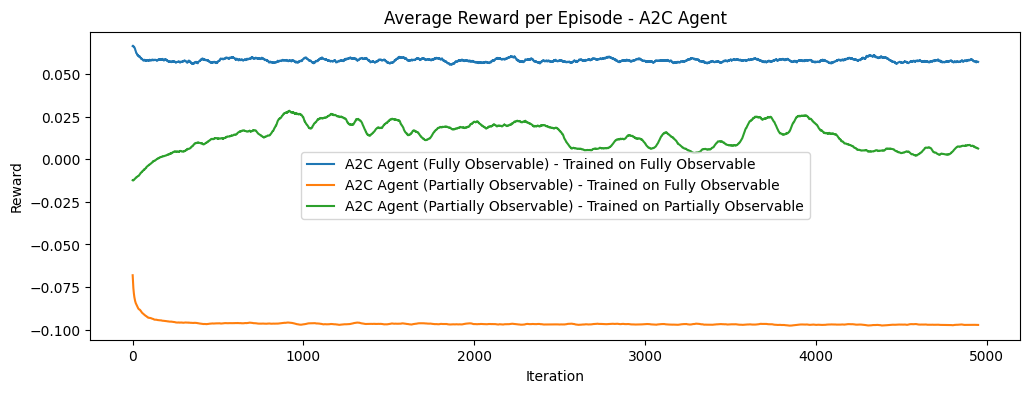

In [19]:
plt.figure(figsize=(12, 4))

plt.plot(moving_average(rewards_history_loaded_ac, window), label='A2C Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(rewards_history_loaded_ac_po, window), label='A2C Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(rewards_history_a2c_po, window), label='A2C Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Reward per Episode - A2C Agent')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend()
plt.savefig("plots/rewards_a2c.png", bbox_inches='tight')
plt.show()
plt.close()

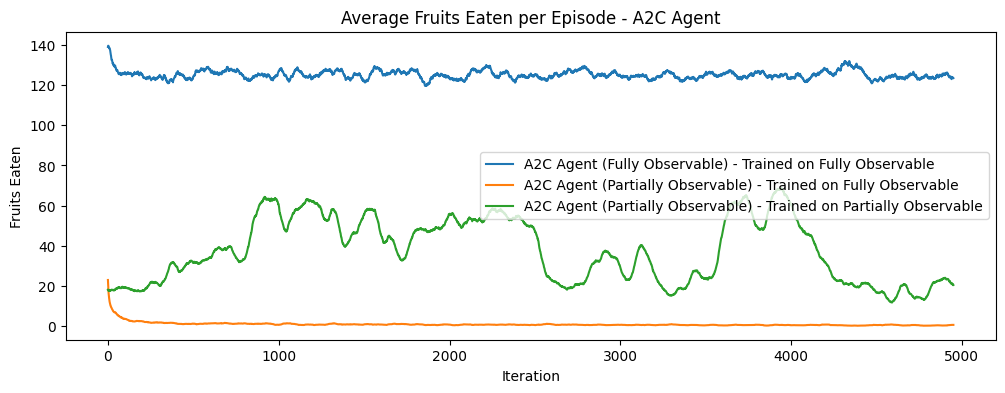

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(fruits_eaten_loaded_ac, window), label='A2C Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(fruits_eaten_loaded_ac_po, window), label='A2C Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(fruits_eaten_a2c_po, window), label='A2C Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Fruits Eaten per Episode - A2C Agent')
plt.xlabel('Iteration')
plt.ylabel('Fruits Eaten')
plt.legend()
plt.savefig("plots/fruits_eaten_a2c.png", bbox_inches='tight')
plt.show()
plt.close()

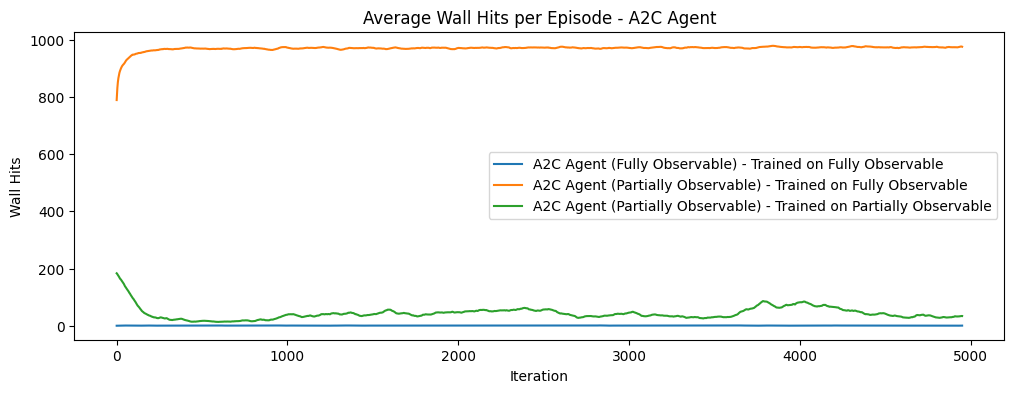

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(wall_hits_loaded_ac, window), label='A2C Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(wall_hits_loaded_ac_po, window), label='A2C Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(wall_hits_a2c_po, window), label='A2C Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Wall Hits per Episode - A2C Agent')
plt.xlabel('Iteration')
plt.ylabel('Wall Hits')
plt.legend()
plt.savefig("plots/wall_hits_a2c.png", bbox_inches='tight')
plt.show()
plt.close()

## Double DQN

### Training

In [22]:
from ddqn import DoubleDQNAgent

env_ = get_env()
agent = DoubleDQNAgent(state_shape=env_.to_state().shape[1:], n_actions=4, buffer_size=10000, batch_size=128, epsilon_start=1., epsilon_end=0.1, epsilon_decay=0.9995, learning_rate=1e-4, gamma=GAMMA, target_update_freq=100)

rewards_history_ddqn, wall_hits_ddqn, fruits_eaten_ddqn, loss_history_ddqn = training(ITERATIONS, env_, agent, save_weights=True, save_path="weights/", file_name="snake_ddqn_weights.h5")

  0%|          | 1/5000 [00:01<2:40:31,  1.93s/it]

Iteration 0: Avg Reward: 0.00, Avg Loss: 0.0428
Fruits eaten: 40, Max fruits eaten: 40
Wall hits: 192


  2%|▏         | 101/5000 [02:38<2:07:26,  1.56s/it]

Iteration 100: Avg Reward: -0.01, Avg Loss: 0.0168
Fruits eaten: 18, Max fruits eaten: 40
Wall hits: 175


  4%|▍         | 201/5000 [05:16<2:07:50,  1.60s/it]

Iteration 200: Avg Reward: -0.01, Avg Loss: 0.0069
Fruits eaten: 20, Max fruits eaten: 40
Wall hits: 185


  6%|▌         | 301/5000 [07:54<2:03:49,  1.58s/it]

Iteration 300: Avg Reward: -0.01, Avg Loss: 0.0066
Fruits eaten: 12, Max fruits eaten: 40
Wall hits: 169


  8%|▊         | 401/5000 [10:34<2:02:45,  1.60s/it]

Iteration 400: Avg Reward: -0.01, Avg Loss: 0.0060
Fruits eaten: 59, Max fruits eaten: 59
Wall hits: 0


 10%|█         | 501/5000 [13:12<1:59:47,  1.60s/it]

Iteration 500: Avg Reward: -0.01, Avg Loss: 0.0063
Fruits eaten: 31, Max fruits eaten: 59
Wall hits: 164


 12%|█▏        | 601/5000 [15:52<1:59:50,  1.63s/it]

Iteration 600: Avg Reward: -0.00, Avg Loss: 0.0086
Fruits eaten: 22, Max fruits eaten: 59
Wall hits: 207


 14%|█▍        | 701/5000 [18:32<1:56:04,  1.62s/it]

Iteration 700: Avg Reward: -0.00, Avg Loss: 0.0092
Fruits eaten: 20, Max fruits eaten: 59
Wall hits: 167


 16%|█▌        | 801/5000 [21:11<1:50:59,  1.59s/it]

Iteration 800: Avg Reward: 0.00, Avg Loss: 0.0092
Fruits eaten: 74, Max fruits eaten: 74
Wall hits: 0


 18%|█▊        | 901/5000 [23:51<1:49:40,  1.61s/it]

Iteration 900: Avg Reward: 0.01, Avg Loss: 0.0109
Fruits eaten: 104, Max fruits eaten: 104
Wall hits: 5


 20%|██        | 1001/5000 [26:30<1:43:35,  1.55s/it]

Iteration 1000: Avg Reward: 0.01, Avg Loss: 0.0115
Fruits eaten: 41, Max fruits eaten: 104
Wall hits: 132


 22%|██▏       | 1101/5000 [29:09<1:44:27,  1.61s/it]

Iteration 1100: Avg Reward: 0.02, Avg Loss: 0.0114
Fruits eaten: 95, Max fruits eaten: 104
Wall hits: 0


 24%|██▍       | 1201/5000 [31:49<1:40:27,  1.59s/it]

Iteration 1200: Avg Reward: 0.03, Avg Loss: 0.0112
Fruits eaten: 54, Max fruits eaten: 104
Wall hits: 161


 26%|██▌       | 1301/5000 [34:29<1:37:30,  1.58s/it]

Iteration 1300: Avg Reward: 0.03, Avg Loss: 0.0155
Fruits eaten: 121, Max fruits eaten: 121
Wall hits: 0


 28%|██▊       | 1401/5000 [37:08<1:36:26,  1.61s/it]

Iteration 1400: Avg Reward: 0.04, Avg Loss: 0.0174
Fruits eaten: 60, Max fruits eaten: 121
Wall hits: 130


 30%|███       | 1501/5000 [39:48<1:34:38,  1.62s/it]

Iteration 1500: Avg Reward: 0.05, Avg Loss: 0.0196
Fruits eaten: 281, Max fruits eaten: 281
Wall hits: 8


 32%|███▏      | 1601/5000 [42:27<1:30:15,  1.59s/it]

Iteration 1600: Avg Reward: 0.05, Avg Loss: 0.0210
Fruits eaten: 129, Max fruits eaten: 281
Wall hits: 2


 34%|███▍      | 1701/5000 [45:08<1:26:08,  1.57s/it]

Iteration 1700: Avg Reward: 0.06, Avg Loss: 0.0233
Fruits eaten: 106, Max fruits eaten: 281
Wall hits: 3


 36%|███▌      | 1801/5000 [47:48<1:26:07,  1.62s/it]

Iteration 1800: Avg Reward: 0.06, Avg Loss: 0.0265
Fruits eaten: 70, Max fruits eaten: 281
Wall hits: 132


 38%|███▊      | 1901/5000 [50:28<1:21:35,  1.58s/it]

Iteration 1900: Avg Reward: 0.06, Avg Loss: 0.0291
Fruits eaten: 55, Max fruits eaten: 281
Wall hits: 129


 40%|████      | 2001/5000 [53:08<1:20:48,  1.62s/it]

Iteration 2000: Avg Reward: 0.04, Avg Loss: 0.0281
Fruits eaten: 56, Max fruits eaten: 281
Wall hits: 148


 42%|████▏     | 2101/5000 [55:48<1:17:09,  1.60s/it]

Iteration 2100: Avg Reward: 0.05, Avg Loss: 0.0273
Fruits eaten: 105, Max fruits eaten: 281
Wall hits: 0


 44%|████▍     | 2201/5000 [58:28<1:13:49,  1.58s/it]

Iteration 2200: Avg Reward: 0.06, Avg Loss: 0.0337
Fruits eaten: 301, Max fruits eaten: 301
Wall hits: 1


 46%|████▌     | 2301/5000 [1:01:08<1:12:04,  1.60s/it]

Iteration 2300: Avg Reward: 0.07, Avg Loss: 0.0287
Fruits eaten: 72, Max fruits eaten: 301
Wall hits: 118


 48%|████▊     | 2401/5000 [1:03:47<1:10:07,  1.62s/it]

Iteration 2400: Avg Reward: 0.07, Avg Loss: 0.0293
Fruits eaten: 295, Max fruits eaten: 301
Wall hits: 5


 50%|█████     | 2501/5000 [1:06:27<1:07:37,  1.62s/it]

Iteration 2500: Avg Reward: 0.08, Avg Loss: 0.0334
Fruits eaten: 271, Max fruits eaten: 301
Wall hits: 6


 52%|█████▏    | 2601/5000 [1:09:07<1:02:35,  1.57s/it]

Iteration 2600: Avg Reward: 0.08, Avg Loss: 0.0346
Fruits eaten: 67, Max fruits eaten: 301
Wall hits: 141


 54%|█████▍    | 2701/5000 [1:11:46<1:01:36,  1.61s/it]

Iteration 2700: Avg Reward: 0.09, Avg Loss: 0.0355
Fruits eaten: 281, Max fruits eaten: 301
Wall hits: 4


 56%|█████▌    | 2801/5000 [1:14:26<58:01,  1.58s/it]  

Iteration 2800: Avg Reward: 0.08, Avg Loss: 0.0385
Fruits eaten: 210, Max fruits eaten: 301
Wall hits: 0


 58%|█████▊    | 2901/5000 [1:17:06<56:52,  1.63s/it]

Iteration 2900: Avg Reward: 0.09, Avg Loss: 0.0402
Fruits eaten: 292, Max fruits eaten: 301
Wall hits: 3


 60%|██████    | 3001/5000 [1:19:46<53:33,  1.61s/it]

Iteration 3000: Avg Reward: 0.07, Avg Loss: 0.0414
Fruits eaten: 233, Max fruits eaten: 301
Wall hits: 1


 62%|██████▏   | 3101/5000 [1:22:26<50:01,  1.58s/it]

Iteration 3100: Avg Reward: 0.09, Avg Loss: 0.0396
Fruits eaten: 62, Max fruits eaten: 301
Wall hits: 130


 64%|██████▍   | 3201/5000 [1:25:06<47:46,  1.59s/it]

Iteration 3200: Avg Reward: 0.10, Avg Loss: 0.0363
Fruits eaten: 270, Max fruits eaten: 301
Wall hits: 9


 66%|██████▌   | 3301/5000 [1:27:45<46:01,  1.63s/it]

Iteration 3300: Avg Reward: 0.08, Avg Loss: 0.0463
Fruits eaten: 33, Max fruits eaten: 301
Wall hits: 151


 68%|██████▊   | 3401/5000 [1:30:25<42:33,  1.60s/it]

Iteration 3400: Avg Reward: 0.10, Avg Loss: 0.0372
Fruits eaten: 277, Max fruits eaten: 301
Wall hits: 3


 70%|███████   | 3501/5000 [1:33:05<39:09,  1.57s/it]

Iteration 3500: Avg Reward: 0.09, Avg Loss: 0.0378
Fruits eaten: 315, Max fruits eaten: 315
Wall hits: 0


 72%|███████▏  | 3601/5000 [1:35:45<37:06,  1.59s/it]

Iteration 3600: Avg Reward: 0.10, Avg Loss: 0.0349
Fruits eaten: 134, Max fruits eaten: 315
Wall hits: 2


 74%|███████▍  | 3701/5000 [1:38:24<34:03,  1.57s/it]

Iteration 3700: Avg Reward: 0.10, Avg Loss: 0.0348
Fruits eaten: 28, Max fruits eaten: 315
Wall hits: 192


 76%|███████▌  | 3801/5000 [1:41:05<32:11,  1.61s/it]

Iteration 3800: Avg Reward: 0.11, Avg Loss: 0.0363
Fruits eaten: 282, Max fruits eaten: 315
Wall hits: 7


 78%|███████▊  | 3901/5000 [1:43:45<29:08,  1.59s/it]

Iteration 3900: Avg Reward: 0.10, Avg Loss: 0.0474
Fruits eaten: 282, Max fruits eaten: 315
Wall hits: 1


 80%|████████  | 4001/5000 [1:46:25<26:12,  1.57s/it]

Iteration 4000: Avg Reward: 0.08, Avg Loss: 0.0531
Fruits eaten: 353, Max fruits eaten: 353
Wall hits: 1


 82%|████████▏ | 4101/5000 [1:49:05<24:08,  1.61s/it]

Iteration 4100: Avg Reward: 0.10, Avg Loss: 0.0441
Fruits eaten: 81, Max fruits eaten: 353
Wall hits: 126


 84%|████████▍ | 4201/5000 [1:51:42<21:20,  1.60s/it]

Iteration 4200: Avg Reward: 0.11, Avg Loss: 0.0403
Fruits eaten: 61, Max fruits eaten: 353
Wall hits: 150


 86%|████████▌ | 4301/5000 [1:54:22<18:52,  1.62s/it]

Iteration 4300: Avg Reward: 0.10, Avg Loss: 0.0482
Fruits eaten: 122, Max fruits eaten: 353
Wall hits: 1


 88%|████████▊ | 4401/5000 [1:57:05<16:02,  1.61s/it]

Iteration 4400: Avg Reward: 0.10, Avg Loss: 0.0480
Fruits eaten: 141, Max fruits eaten: 353
Wall hits: 1


 90%|█████████ | 4501/5000 [1:59:46<13:12,  1.59s/it]

Iteration 4500: Avg Reward: 0.10, Avg Loss: 0.0461
Fruits eaten: 283, Max fruits eaten: 353
Wall hits: 4


 92%|█████████▏| 4601/5000 [2:02:26<10:40,  1.61s/it]

Iteration 4600: Avg Reward: 0.11, Avg Loss: 0.0410
Fruits eaten: 302, Max fruits eaten: 353
Wall hits: 0


 94%|█████████▍| 4701/5000 [2:05:06<08:06,  1.63s/it]

Iteration 4700: Avg Reward: 0.11, Avg Loss: 0.0433
Fruits eaten: 305, Max fruits eaten: 353
Wall hits: 1


 96%|█████████▌| 4801/5000 [2:07:45<05:19,  1.61s/it]

Iteration 4800: Avg Reward: 0.12, Avg Loss: 0.0377
Fruits eaten: 79, Max fruits eaten: 353
Wall hits: 165


 98%|█████████▊| 4901/5000 [2:10:25<02:37,  1.59s/it]

Iteration 4900: Avg Reward: 0.12, Avg Loss: 0.0441
Fruits eaten: 277, Max fruits eaten: 353
Wall hits: 1


100%|██████████| 5000/5000 [2:13:04<00:00,  1.60s/it]

Model weights saved to weights/snake_ddqn_weights.h5
Weights saved to weights/snake_ddqn_weights.h5


### Load the weights - DDQN Agent

In [23]:
from ddqn import DoubleDQNAgent

env = get_env()
agent = DoubleDQNAgent(state_shape=env.to_state().shape[1:], n_actions=4, buffer_size=10000, batch_size=128, epsilon_start=1., epsilon_end=0.1, epsilon_decay=0.9995, learning_rate=1e-4, gamma=GAMMA, target_update_freq=100)
agent.load_weights("weights/snake_ddqn_weights.h5")

rewards_history_loaded_ddqn = []
wall_hits_loaded_ddqn = []
fruits_eaten_loaded_ddqn = []

for iteration in trange(ITERATIONS):
    state = tf.constant(env.to_state())
    actions = agent.select_action(state)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_loaded_ddqn.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_loaded_ddqn.append(fruits_eaten_count)
    rewards_history_loaded_ddqn.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

print(f"Avg Reward: {np.mean(rewards_history_loaded_ddqn):.2f}")
print(f"Avg Wall Hits: {np.mean(wall_hits_loaded_ddqn):.2f}")
print(f"Avg Fruits Eaten: {np.mean(fruits_eaten_loaded_ddqn):.2f}")

Model weights loaded from weights/snake_ddqn_weights.h5


100%|██████████| 5000/5000 [02:16<00:00, 36.63it/s]

Avg Reward: 0.11
Avg Wall Hits: 15.52
Avg Fruits Eaten: 247.91


### Load the weights - Testing on Partially Observable Environment

In [24]:
env = get_env(partially_observable=True)
agent = DoubleDQNAgent(state_shape=env.to_state().shape[1:], n_actions=4, buffer_size=10000, batch_size=128, epsilon_start=1., epsilon_end=0.1, epsilon_decay=0.9995, learning_rate=1e-4, gamma=GAMMA, target_update_freq=100)
agent.load_weights("weights/snake_ddqn_weights.h5")

rewards_history_loaded_ddqn_po = []
wall_hits_loaded_ddqn_po = []
fruits_eaten_loaded_ddqn_po = []
loss_history_loaded_ddqn_po = []

for iteration in trange(ITERATIONS):
    state = tf.constant(env.to_state())
    actions = agent.select_action(state)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_loaded_ddqn_po.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_loaded_ddqn_po.append(fruits_eaten_count)
    rewards_history_loaded_ddqn_po.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

print(f"Avg Reward: {np.mean(rewards_history_loaded_ddqn_po):.2f}")
print(f"Avg Wall Hits: {np.mean(wall_hits_loaded_ddqn_po):.2f}")
print(f"Avg Fruits Eaten: {np.mean(fruits_eaten_loaded_ddqn_po):.2f}")

Model weights loaded from weights/snake_ddqn_weights.h5


100%|██████████| 5000/5000 [01:35<00:00, 52.19it/s]

Avg Reward: -0.08
Avg Wall Hits: 879.09
Avg Fruits Eaten: 7.53


Here we train the model on the partially observable environment

In [25]:
env = get_env(partially_observable=True)
agent = DoubleDQNAgent(state_shape=env.to_state().shape[1:], n_actions=4, buffer_size=10000, batch_size=128, epsilon_start=1., epsilon_end=0.1, epsilon_decay=0.9995, learning_rate=1e-4, gamma=GAMMA, target_update_freq=100)

rewards_history_ddqn_po, wall_hits_ddqn_po, fruits_eaten_ddqn_po, loss_history_ddqn_po = training(ITERATIONS, env, agent, save_weights=True, save_path="weights/", file_name="snake_ddqn_weights_po.h5")

  0%|          | 1/5000 [00:01<2:21:21,  1.70s/it]

Iteration 0: Avg Reward: -0.01, Avg Loss: 0.0170
Fruits eaten: 24, Max fruits eaten: 24
Wall hits: 197


  2%|▏         | 101/5000 [02:38<2:10:08,  1.59s/it]

Iteration 100: Avg Reward: -0.01, Avg Loss: 0.0081
Fruits eaten: 25, Max fruits eaten: 25
Wall hits: 203


  4%|▍         | 201/5000 [05:19<2:09:56,  1.62s/it]

Iteration 200: Avg Reward: -0.01, Avg Loss: 0.0038
Fruits eaten: 15, Max fruits eaten: 25
Wall hits: 209


  6%|▌         | 301/5000 [07:59<2:06:57,  1.62s/it]

Iteration 300: Avg Reward: -0.01, Avg Loss: 0.0048
Fruits eaten: 43, Max fruits eaten: 43
Wall hits: 126


  8%|▊         | 401/5000 [10:40<2:01:28,  1.58s/it]

Iteration 400: Avg Reward: -0.00, Avg Loss: 0.0095
Fruits eaten: 29, Max fruits eaten: 43
Wall hits: 188


 10%|█         | 501/5000 [13:20<1:59:19,  1.59s/it]

Iteration 500: Avg Reward: 0.01, Avg Loss: 0.0143
Fruits eaten: 88, Max fruits eaten: 88
Wall hits: 2


 12%|█▏        | 601/5000 [16:01<1:55:53,  1.58s/it]

Iteration 600: Avg Reward: 0.01, Avg Loss: 0.0173
Fruits eaten: 32, Max fruits eaten: 88
Wall hits: 185


 14%|█▍        | 701/5000 [18:41<1:56:19,  1.62s/it]

Iteration 700: Avg Reward: 0.01, Avg Loss: 0.0221
Fruits eaten: 27, Max fruits eaten: 88
Wall hits: 178


 16%|█▌        | 801/5000 [21:21<1:52:13,  1.60s/it]

Iteration 800: Avg Reward: 0.03, Avg Loss: 0.0260
Fruits eaten: 99, Max fruits eaten: 99
Wall hits: 0


 18%|█▊        | 901/5000 [24:02<1:50:38,  1.62s/it]

Iteration 900: Avg Reward: 0.01, Avg Loss: 0.0228
Fruits eaten: 65, Max fruits eaten: 99
Wall hits: 83


 20%|██        | 1001/5000 [26:43<1:46:45,  1.60s/it]

Iteration 1000: Avg Reward: 0.03, Avg Loss: 0.0258
Fruits eaten: 20, Max fruits eaten: 99
Wall hits: 201


 22%|██▏       | 1101/5000 [29:24<1:43:59,  1.60s/it]

Iteration 1100: Avg Reward: 0.02, Avg Loss: 0.0258
Fruits eaten: 64, Max fruits eaten: 99
Wall hits: 117


 24%|██▍       | 1201/5000 [32:05<1:43:14,  1.63s/it]

Iteration 1200: Avg Reward: 0.03, Avg Loss: 0.0269
Fruits eaten: 289, Max fruits eaten: 289
Wall hits: 0


 26%|██▌       | 1301/5000 [34:46<1:40:13,  1.63s/it]

Iteration 1300: Avg Reward: 0.04, Avg Loss: 0.0286
Fruits eaten: 290, Max fruits eaten: 290
Wall hits: 4


 28%|██▊       | 1401/5000 [37:26<1:36:34,  1.61s/it]

Iteration 1400: Avg Reward: 0.03, Avg Loss: 0.0367
Fruits eaten: 69, Max fruits eaten: 290
Wall hits: 101


 30%|███       | 1501/5000 [40:07<1:33:49,  1.61s/it]

Iteration 1500: Avg Reward: 0.04, Avg Loss: 0.0392
Fruits eaten: 140, Max fruits eaten: 290
Wall hits: 1


 32%|███▏      | 1601/5000 [42:49<1:29:28,  1.58s/it]

Iteration 1600: Avg Reward: 0.04, Avg Loss: 0.0365
Fruits eaten: 30, Max fruits eaten: 290
Wall hits: 160


 34%|███▍      | 1701/5000 [45:29<1:29:07,  1.62s/it]

Iteration 1700: Avg Reward: 0.06, Avg Loss: 0.0370
Fruits eaten: 259, Max fruits eaten: 290
Wall hits: 2


 36%|███▌      | 1801/5000 [48:11<1:26:40,  1.63s/it]

Iteration 1800: Avg Reward: 0.05, Avg Loss: 0.0403
Fruits eaten: 32, Max fruits eaten: 290
Wall hits: 175


 38%|███▊      | 1901/5000 [50:51<1:24:36,  1.64s/it]

Iteration 1900: Avg Reward: 0.06, Avg Loss: 0.0340
Fruits eaten: 30, Max fruits eaten: 290
Wall hits: 135


 40%|████      | 2001/5000 [53:32<1:18:57,  1.58s/it]

Iteration 2000: Avg Reward: 0.06, Avg Loss: 0.0370
Fruits eaten: 61, Max fruits eaten: 290
Wall hits: 148


 42%|████▏     | 2101/5000 [56:13<1:16:41,  1.59s/it]

Iteration 2100: Avg Reward: 0.07, Avg Loss: 0.0392
Fruits eaten: 32, Max fruits eaten: 290
Wall hits: 149


 44%|████▍     | 2201/5000 [58:55<1:15:04,  1.61s/it]

Iteration 2200: Avg Reward: 0.06, Avg Loss: 0.0392
Fruits eaten: 242, Max fruits eaten: 290
Wall hits: 0


 46%|████▌     | 2301/5000 [1:01:36<1:12:42,  1.62s/it]

Iteration 2300: Avg Reward: 0.06, Avg Loss: 0.0403
Fruits eaten: 312, Max fruits eaten: 312
Wall hits: 1


 48%|████▊     | 2401/5000 [1:04:17<1:10:25,  1.63s/it]

Iteration 2400: Avg Reward: 0.08, Avg Loss: 0.0380
Fruits eaten: 358, Max fruits eaten: 358
Wall hits: 0


 50%|█████     | 2501/5000 [1:06:58<1:07:39,  1.62s/it]

Iteration 2500: Avg Reward: 0.08, Avg Loss: 0.0398
Fruits eaten: 317, Max fruits eaten: 358
Wall hits: 0


 52%|█████▏    | 2601/5000 [1:09:38<1:04:13,  1.61s/it]

Iteration 2600: Avg Reward: 0.08, Avg Loss: 0.0403
Fruits eaten: 264, Max fruits eaten: 358
Wall hits: 6


 54%|█████▍    | 2701/5000 [1:12:19<59:53,  1.56s/it]  

Iteration 2700: Avg Reward: 0.08, Avg Loss: 0.0411
Fruits eaten: 92, Max fruits eaten: 358
Wall hits: 115


 56%|█████▌    | 2801/5000 [1:14:59<58:32,  1.60s/it]  

Iteration 2800: Avg Reward: 0.07, Avg Loss: 0.0412
Fruits eaten: 76, Max fruits eaten: 358
Wall hits: 141


 58%|█████▊    | 2901/5000 [1:17:40<55:52,  1.60s/it]  

Iteration 2900: Avg Reward: 0.08, Avg Loss: 0.0392
Fruits eaten: 318, Max fruits eaten: 358
Wall hits: 1


 60%|██████    | 3001/5000 [1:20:20<54:00,  1.62s/it]

Iteration 3000: Avg Reward: 0.08, Avg Loss: 0.0376
Fruits eaten: 128, Max fruits eaten: 358
Wall hits: 1


 62%|██████▏   | 3101/5000 [1:23:01<50:43,  1.60s/it]

Iteration 3100: Avg Reward: 0.08, Avg Loss: 0.0441
Fruits eaten: 287, Max fruits eaten: 358
Wall hits: 1


 64%|██████▍   | 3201/5000 [1:25:42<47:17,  1.58s/it]

Iteration 3200: Avg Reward: 0.09, Avg Loss: 0.0397
Fruits eaten: 65, Max fruits eaten: 358
Wall hits: 149


 66%|██████▌   | 3301/5000 [1:28:23<45:27,  1.61s/it]

Iteration 3300: Avg Reward: 0.09, Avg Loss: 0.0422
Fruits eaten: 61, Max fruits eaten: 358
Wall hits: 153


 68%|██████▊   | 3401/5000 [1:31:03<42:45,  1.60s/it]

Iteration 3400: Avg Reward: 0.10, Avg Loss: 0.0398
Fruits eaten: 124, Max fruits eaten: 358
Wall hits: 1


 70%|███████   | 3501/5000 [1:33:44<40:14,  1.61s/it]

Iteration 3500: Avg Reward: 0.10, Avg Loss: 0.0373
Fruits eaten: 263, Max fruits eaten: 358
Wall hits: 3


 72%|███████▏  | 3601/5000 [1:36:25<37:26,  1.61s/it]

Iteration 3600: Avg Reward: 0.10, Avg Loss: 0.0367
Fruits eaten: 49, Max fruits eaten: 358
Wall hits: 145


 74%|███████▍  | 3701/5000 [1:39:06<34:21,  1.59s/it]

Iteration 3700: Avg Reward: 0.09, Avg Loss: 0.0384
Fruits eaten: 130, Max fruits eaten: 358
Wall hits: 1


 76%|███████▌  | 3801/5000 [1:41:46<32:03,  1.60s/it]

Iteration 3800: Avg Reward: 0.10, Avg Loss: 0.0326
Fruits eaten: 265, Max fruits eaten: 358
Wall hits: 1


 78%|███████▊  | 3901/5000 [1:44:28<29:51,  1.63s/it]

Iteration 3900: Avg Reward: 0.11, Avg Loss: 0.0319
Fruits eaten: 298, Max fruits eaten: 358
Wall hits: 2


 80%|████████  | 4001/5000 [1:47:08<26:55,  1.62s/it]

Iteration 4000: Avg Reward: 0.08, Avg Loss: 0.0429
Fruits eaten: 272, Max fruits eaten: 358
Wall hits: 4


 82%|████████▏ | 4101/5000 [1:49:49<24:01,  1.60s/it]

Iteration 4100: Avg Reward: 0.09, Avg Loss: 0.0382
Fruits eaten: 276, Max fruits eaten: 358
Wall hits: 1


 84%|████████▍ | 4201/5000 [1:52:30<21:11,  1.59s/it]

Iteration 4200: Avg Reward: 0.11, Avg Loss: 0.0355
Fruits eaten: 293, Max fruits eaten: 358
Wall hits: 3


 86%|████████▌ | 4301/5000 [1:55:11<18:26,  1.58s/it]

Iteration 4300: Avg Reward: 0.10, Avg Loss: 0.0328
Fruits eaten: 275, Max fruits eaten: 358
Wall hits: 2


 88%|████████▊ | 4401/5000 [1:57:52<15:56,  1.60s/it]

Iteration 4400: Avg Reward: 0.10, Avg Loss: 0.0393
Fruits eaten: 282, Max fruits eaten: 358
Wall hits: 1


 90%|█████████ | 4501/5000 [2:00:33<13:18,  1.60s/it]

Iteration 4500: Avg Reward: 0.11, Avg Loss: 0.0348
Fruits eaten: 60, Max fruits eaten: 358
Wall hits: 148


 92%|█████████▏| 4601/5000 [2:03:11<10:24,  1.56s/it]

Iteration 4600: Avg Reward: 0.10, Avg Loss: 0.0412
Fruits eaten: 341, Max fruits eaten: 358
Wall hits: 0


 94%|█████████▍| 4701/5000 [2:05:52<07:59,  1.60s/it]

Iteration 4700: Avg Reward: 0.11, Avg Loss: 0.0445
Fruits eaten: 265, Max fruits eaten: 358
Wall hits: 1


 96%|█████████▌| 4801/5000 [2:08:33<05:15,  1.59s/it]

Iteration 4800: Avg Reward: 0.12, Avg Loss: 0.0407
Fruits eaten: 292, Max fruits eaten: 358
Wall hits: 0


 98%|█████████▊| 4901/5000 [2:11:14<02:39,  1.61s/it]

Iteration 4900: Avg Reward: 0.10, Avg Loss: 0.0484
Fruits eaten: 248, Max fruits eaten: 358
Wall hits: 0


100%|██████████| 5000/5000 [2:13:53<00:00,  1.61s/it]

Model weights saved to weights/snake_ddqn_weights_po.h5
Weights saved to weights/snake_ddqn_weights_po.h5


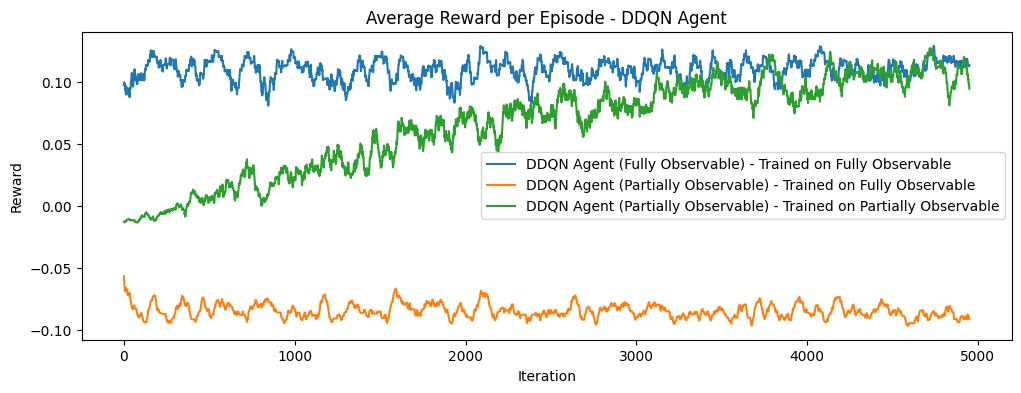

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(rewards_history_loaded_ddqn, window), label='DDQN Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(rewards_history_loaded_ddqn_po, window), label='DDQN Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(rewards_history_ddqn_po, window), label='DDQN Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Reward per Episode - DDQN Agent')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend()
plt.savefig("plots/rewards_ddqn.png", bbox_inches='tight')
plt.show()
plt.close()

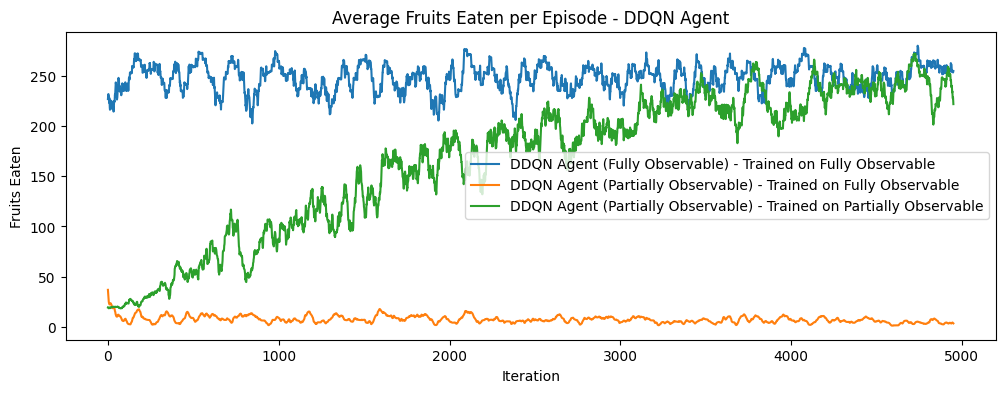

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(fruits_eaten_loaded_ddqn, window), label='DDQN Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(fruits_eaten_loaded_ddqn_po, window), label='DDQN Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(fruits_eaten_ddqn_po, window), label='DDQN Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Fruits Eaten per Episode - DDQN Agent')
plt.xlabel('Iteration')
plt.ylabel('Fruits Eaten')
plt.legend()
plt.savefig("plots/fruits_eaten_ddqn.png", bbox_inches='tight')
plt.show()
plt.close()

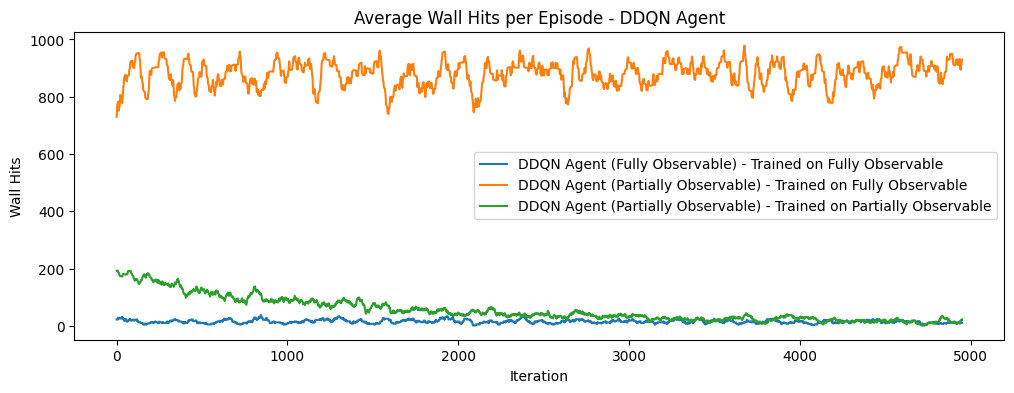

In [28]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(wall_hits_loaded_ddqn, window), label='DDQN Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(wall_hits_loaded_ddqn_po, window), label='DDQN Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(wall_hits_ddqn_po, window), label='DDQN Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Wall Hits per Episode - DDQN Agent')
plt.xlabel('Iteration')
plt.ylabel('Wall Hits')
plt.legend()
plt.savefig("plots/wall_hits_ddqn.png", bbox_inches='tight')
plt.show()
plt.close()

## Heuristic/Baseline Policy

1. **Greedy move toward the fruit**: trying to reduce the Manhattan distance between the head of the snake and the fruit.
2. **Obstacle avoidance**: before moving in the greedy direction, ensure to not hit an obstacle or eat itself
3. **Fallback strategy**: if the snake cannot reach the greedy direction, try the second best one, and so forth so on

In [29]:
from baseline import heuristic_policy

env = get_env()
heuristic_rewards = []
fruits_eaten_heuristic = []
wall_hits_heuristic = []

for iteration in trange(ITERATIONS):
    actions = heuristic_policy(env)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_heuristic.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_heuristic.append(fruits_eaten_count)
    heuristic_rewards.append(np.mean(rewards))

100%|██████████| 5000/5000 [03:19<00:00, 25.08it/s]


### Heuristic - Partially Observable Environment

In [30]:
env = get_env(partially_observable=True)
heuristic_rewards_po = []
fruits_eaten_heuristic_po = []
wall_hits_heuristic_po = []

for iteration in trange(ITERATIONS):
    actions = heuristic_policy(env)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_heuristic_po.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_heuristic_po.append(fruits_eaten_count)
    heuristic_rewards_po.append(np.mean(rewards))

100%|██████████| 5000/5000 [03:19<00:00, 25.10it/s]


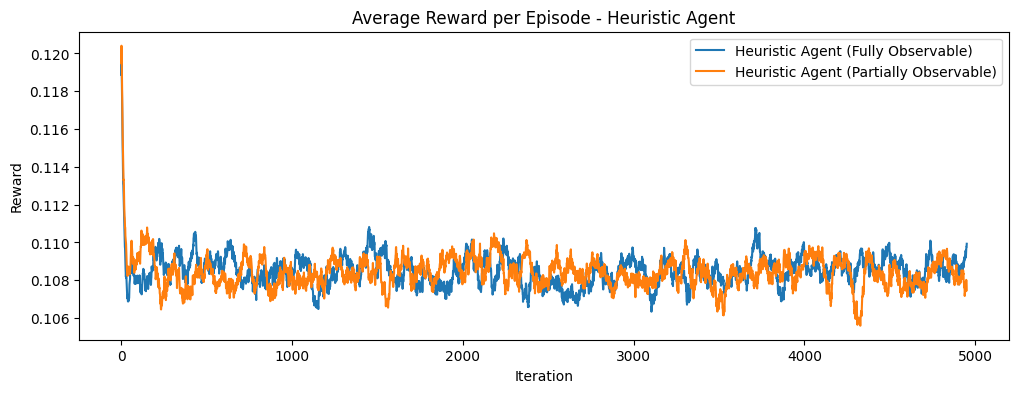

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(heuristic_rewards, window), label='Heuristic Agent (Fully Observable)')
plt.plot(moving_average(heuristic_rewards_po, window), label='Heuristic Agent (Partially Observable)')
plt.title('Average Reward per Episode - Heuristic Agent')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend()
plt.savefig("plots/rewards_heuristic.png", bbox_inches='tight')
plt.show()
plt.close()

 ### Random policy reward
 
Just a baseline (not the one you are supposed to develop)

In [32]:
random_env = get_env(100)
random_rewards = []

for _ in trange(ITERATIONS):
    probs = tf.convert_to_tensor([[.25]*4]*random_env.n_boards)
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)
    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(np.mean(rewards))

100%|██████████| 5000/5000 [00:19<00:00, 252.36it/s]


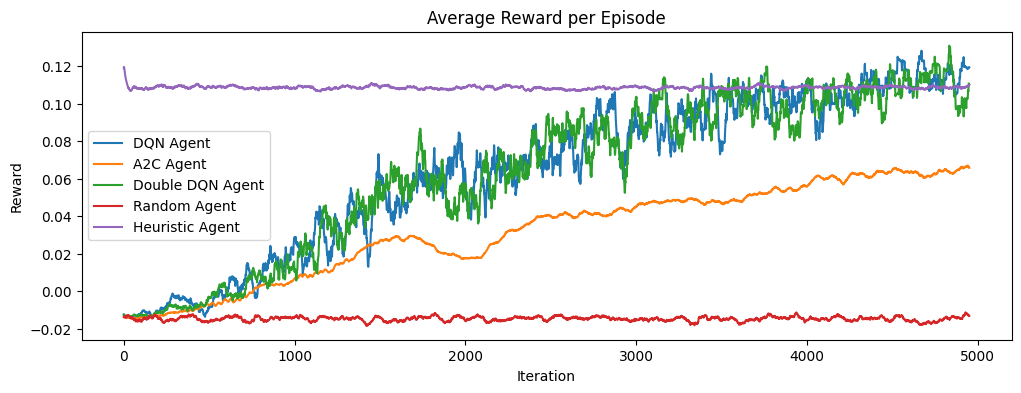

In [33]:
window = 50

def moving_average(data, window):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 4))

plt.plot(moving_average(rewards_history_dqn, window), label='DQN Agent')
plt.plot(moving_average(rewards_history_ac, window), label='A2C Agent')
plt.plot(moving_average(rewards_history_ddqn, window), label='Double DQN Agent')
plt.plot(moving_average(random_rewards, window), label='Random Agent')
plt.plot(moving_average(heuristic_rewards, window), label='Heuristic Agent')
plt.title('Average Reward per Episode')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend()
plt.savefig("plots/rewards.png", bbox_inches='tight')
plt.show()
plt.close()

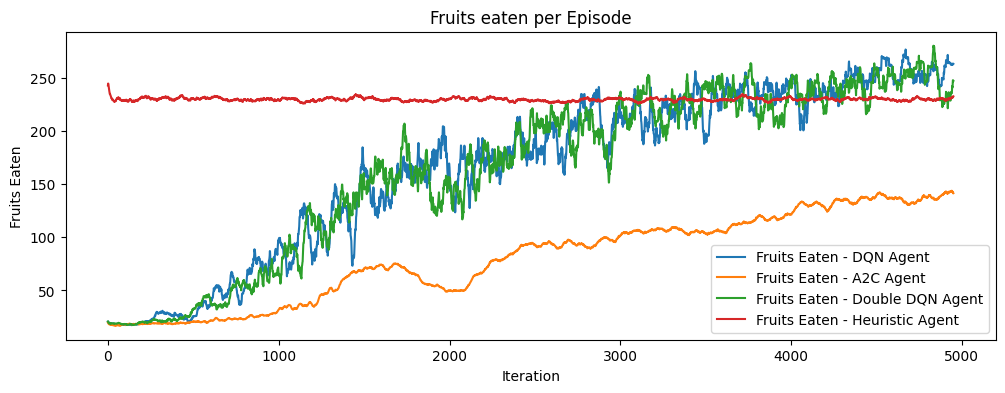

In [34]:
# Plot the fruits eaten
plt.figure(figsize=(12, 4))
plt.plot(moving_average(fruits_eaten_dqn, window), label='Fruits Eaten - DQN Agent')
plt.plot(moving_average(fruits_eaten_ac, window), label='Fruits Eaten - A2C Agent')
plt.plot(moving_average(fruits_eaten_ddqn, window), label='Fruits Eaten - Double DQN Agent')
plt.plot(moving_average(fruits_eaten_heuristic, window), label='Fruits Eaten - Heuristic Agent')
plt.title('Fruits eaten per Episode')
plt.xlabel('Iteration')
plt.ylabel('Fruits Eaten')
plt.legend()
plt.savefig("plots/fruits_eaten.png", bbox_inches='tight')
plt.show()
plt.close()

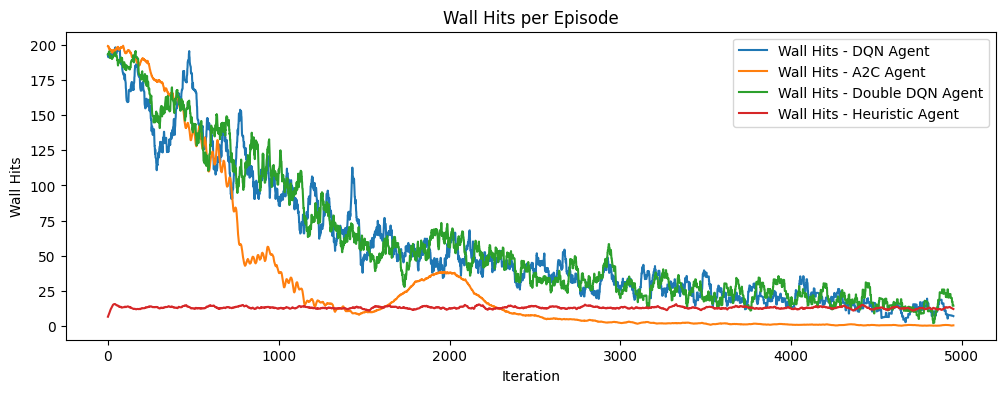

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(wall_hits_dqn, window), label='Wall Hits - DQN Agent')
plt.plot(moving_average(wall_hits_ac, window), label='Wall Hits - A2C Agent')
plt.plot(moving_average(wall_hits_ddqn, window), label='Wall Hits - Double DQN Agent')
plt.plot(moving_average(wall_hits_heuristic, window), label='Wall Hits - Heuristic Agent')
plt.title('Wall Hits per Episode')
plt.xlabel('Iteration')
plt.ylabel('Wall Hits')
plt.legend()
plt.savefig("plots/wall_hits.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()